### Task A init

In [2]:
import numpy as np
data = np.load('./Datasets/pneumoniamnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()

[1214 3494]
[135 389]


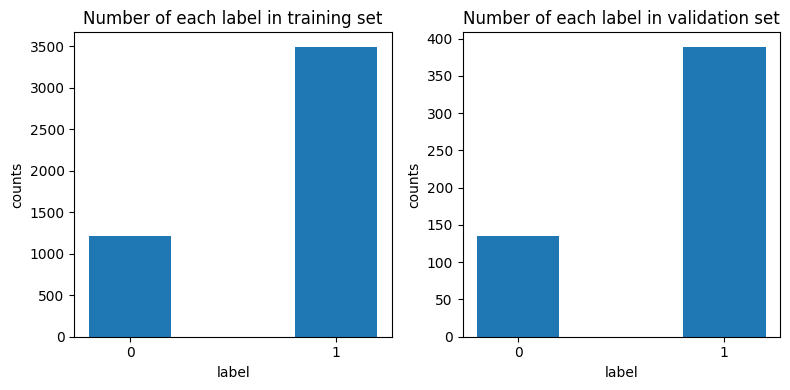

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots(1,2, figsize=(8,4))
values, counts = np.unique(ytrain, return_counts=True)
print(counts)
ax[0].bar(values, counts, width=0.4)
ax[0].set_title("Number of each label in training set")
ax[0].set_xlabel("label")
ax[0].set_ylabel("counts")
ax[0].set_xticks([0, 1])
values, counts = np.unique(yval, return_counts=True)
print(counts)
ax[1].bar(values, counts, width=0.4)
ax[1].set_title("Number of each label in validation set")
ax[1].set_xlabel("label")
ax[1].set_ylabel("counts")
ax[1].set_xticks([0, 1])
# plt.figure(figsize=(5,5))
# plt.bar(values, counts, width=0.4)
# plt.xlabel('label')
# plt.ylabel('Counts')
# plt.xticks([0, 1])
# plt.title('Frequency of each label')
plt.tight_layout()
plt.savefig("A/figures/label-frequency.png")


### Data augmentation

In [11]:
import torch
from torchvision import transforms
def augment_training_data(xtrain, ytrain, num_transformed_images=2280):
    """ augment data with label 0 to make it a balanced dataset """

    xtrain_label0 = xtrain[ytrain.flatten()==0]
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ToTensor(),
    ])
    transformed_images = []
    while len(transformed_images) < num_transformed_images:
        for img in xtrain_label0:
            img_tensor = torch.tensor(img)
            img_transformed = transform(img_tensor).numpy() * 255
            transformed_images.append(img_transformed)
            if len(transformed_images) >= num_transformed_images:
                break
    augmented_images = np.array(transformed_images)[:,0,:,:]
    augmented_xtrain = np.concatenate([xtrain, augmented_images], axis=0)
    augmented_ytrain = np.concatenate([ytrain, np.zeros((2280, 1))])
    return augmented_xtrain, augmented_ytrain

In [12]:
augmented_xtrain, augmented_ytrain = augment_training_data(xtrain, ytrain)
print(augmented_xtrain.shape)
print(augmented_ytrain.shape)
print(augmented_ytrain[-10:,:])
print(augmented_ytrain[10:,:])

(6988, 28, 28)
(6988, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


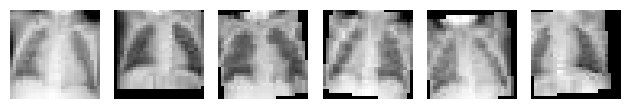

In [13]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(augmented_xtrain[-i], cmap='gray')
    plt.axis("off")
plt.tight_layout()

In [15]:
import torch
from torchvision import transforms
xtrain_label0 = xtrain[ytrain.flatten()==0]

In [27]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(28, padding=4),  # 随机裁剪，添加填充
    transforms.RandomHorizontalFlip(),     # 随机水平翻转
    transforms.ToTensor(),                 # 转换为Tensor
])

def apply_transforms(images, num_transformed_images):
    transformed_images = []
    while len(transformed_images) < num_transformed_images:
        for img in images:
            img_tensor = torch.tensor(img)
            img_transformed = transform(img_tensor).numpy() * 255
            transformed_images.append(img_transformed)
            if len(transformed_images) >= num_transformed_images:
                break
    return np.array(transformed_images)[:,0,:,:]

In [32]:
augmented_images = apply_transforms(xtrain_label0, num_transformed_images=3494-1214)
augmented_images.shape

(2280, 28, 28)

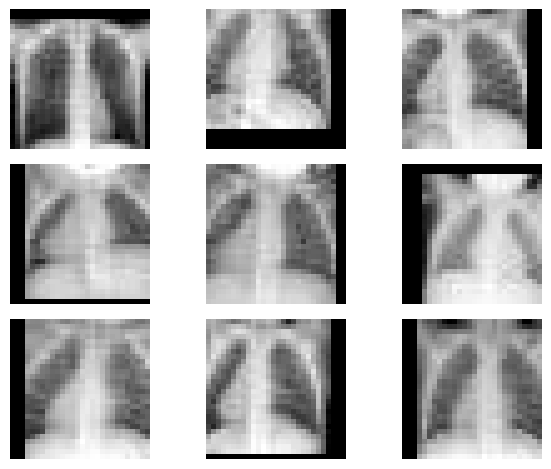

In [33]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i], cmap='gray')
    plt.axis("off")
plt.tight_layout()

In [38]:
augmented_xtrain = np.concatenate([xtrain, augmented_images], axis=0)

In [39]:
augmented_xtrain.shape

(6988, 28, 28)

### CNN test

Epoch 1, Training Loss: 0.4187985669482838
Epoch 1, Validated Accuracy: 0.8950381679389313
Epoch 2, Training Loss: 0.20397094897925855
Epoch 2, Validated Accuracy: 0.916030534351145
Epoch 3, Training Loss: 0.19225932830436662
Epoch 3, Validated Accuracy: 0.9465648854961832
Epoch 4, Training Loss: 0.17930732701312413
Epoch 4, Validated Accuracy: 0.9427480916030534
Epoch 5, Training Loss: 0.15594537457959218
Epoch 5, Validated Accuracy: 0.9484732824427481
Epoch 6, Training Loss: 0.16376319934021344
Epoch 6, Validated Accuracy: 0.9522900763358778
Epoch 7, Training Loss: 0.16634872626851904
Epoch 7, Validated Accuracy: 0.9408396946564885
Epoch 8, Training Loss: 0.15636155683208597
Epoch 8, Validated Accuracy: 0.9389312977099237
Epoch 9, Training Loss: 0.1494120441885157
Epoch 9, Validated Accuracy: 0.933206106870229
Epoch 10, Training Loss: 0.15978267839686436
Epoch 10, Validated Accuracy: 0.9351145038167938
Epoch 11, Training Loss: 0.1461032637818293
Epoch 11, Validated Accuracy: 0.948473

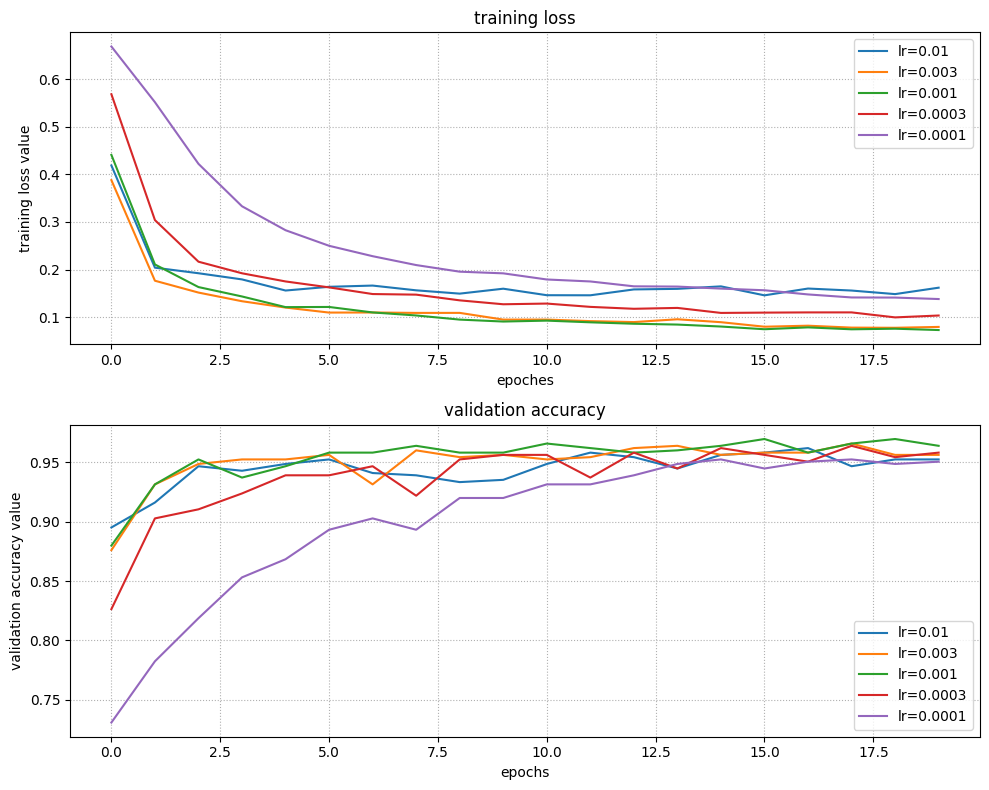

In [5]:
# learning rate tuning
from A.cnn import *
from A.preprocessing import *
import matplotlib.pyplot as plt
seed_everything(seed=42)
data = np.load('./Datasets/pneumoniamnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
xtrain, ytrain = training_data_augmentation(xtrain, ytrain)
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)
lrs = [0.01, 0.003, 0.001, 0.0003, 0.0001]
fig, ax = plt.subplots(2, 1, figsize=(10,8))
for lr in lrs:
    conv = [(16, 3, 1, 1), (32, 3, 1, 1)]
    fc = [32*7*7, 128]
    cnn = CNN(input_channels=1, output_size=2, conv_layers=conv, fc_layers=fc, dropout_conv=0.3, dropout_fc=0.6)
    # print(cnn)
    training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=20, lr = lr, use_validation=True)
    ax[0].plot(training_loss, label=f'lr={lr}')
    ax[0].set_xlabel("epoches")
    ax[0].set_ylabel("training loss value")
    ax[0].set_title("training loss")
    ax[0].legend()
    ax[0].grid(ls=':')
    ax[1].plot(val_accuracy, label=f'lr={lr}')
    ax[1].legend()
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("validation accuracy value")
    ax[1].set_title("validation accuracy")
    ax[1].grid(ls=':')

plt.tight_layout()
plt.savefig("A/figures/lr_tuning_aug.png")


Epoch 1, Training Loss: 0.4989535774696957
Epoch 1, Validated Accuracy: 0.8320610687022901
Epoch 2, Training Loss: 0.2693838279355656
Epoch 2, Validated Accuracy: 0.8950381679389313
Epoch 3, Training Loss: 0.20818867378614164
Epoch 3, Validated Accuracy: 0.9370229007633588
Epoch 4, Training Loss: 0.1831422430209138
Epoch 4, Validated Accuracy: 0.9351145038167938
Epoch 5, Training Loss: 0.1640921435911547
Epoch 5, Validated Accuracy: 0.9370229007633588
Epoch 6, Training Loss: 0.15648719990117985
Epoch 6, Validated Accuracy: 0.933206106870229
Epoch 7, Training Loss: 0.15052795504981822
Epoch 7, Validated Accuracy: 0.9446564885496184
Epoch 8, Training Loss: 0.139928547445346
Epoch 8, Validated Accuracy: 0.9446564885496184
Epoch 9, Training Loss: 0.13331227021461184
Epoch 9, Validated Accuracy: 0.9370229007633588
Epoch 10, Training Loss: 0.13302993208847264
Epoch 10, Validated Accuracy: 0.9484732824427481
Epoch 11, Training Loss: 0.12799171764742245
Epoch 11, Validated Accuracy: 0.93893129

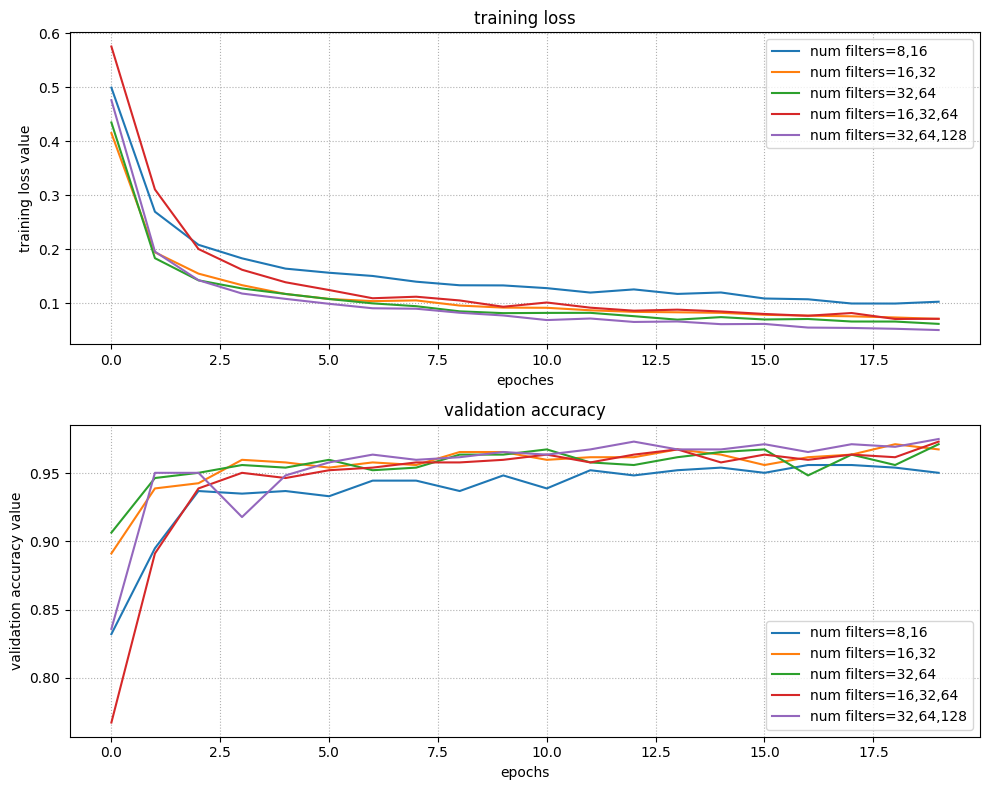

In [7]:
# conv layer tuning
from A.cnn import *
from A.preprocessing import *
import matplotlib.pyplot as plt
seed_everything(seed=42)
data = np.load('./Datasets/pneumoniamnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
xtrain, ytrain = training_data_augmentation(xtrain, ytrain)
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)
lrs = [0.01, 0.003, 0.001, 0.0003, 0.0001]
fig, ax = plt.subplots(2, 1, figsize=(10,8))
convs = [[(8, 3, 1, 1), [16, 3, 1, 1]],
         [(16, 3, 1, 1), (32, 3, 1, 1)], 
         [(32, 3, 1, 1), (64, 3, 1, 1)], 
         [(16, 3, 1, 1), (32, 3, 1, 1), (64, 3, 1, 1)], 
         [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]]
fcs = [[16*7*7, 128],
       [32*7*7, 128], 
       [64*7*7, 128],
       [64*3*3, 128],
       [128*3*3, 128]]
filters = ["8,16", "16,32", "32,64", "16,32,64", "32,64,128"]
for conv, fc, filter in zip(convs, fcs, filters):
    cnn = CNN(input_channels=1, output_size=2, conv_layers=conv, fc_layers=fc, dropout_conv=0.3, dropout_fc=0.6)
    training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=20, lr = 0.001, use_validation=True)
    ax[0].plot(training_loss, label=f'num filters={filter}')
    ax[0].set_xlabel("epoches")
    ax[0].set_ylabel("training loss value")
    ax[0].set_title("training loss")
    ax[0].legend()
    ax[0].grid(ls=':')
    ax[1].plot(val_accuracy, label=f'num filters={filter}')
    ax[1].legend()
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("validation accuracy value")
    ax[1].set_title("validation accuracy")
    ax[1].grid(ls=':')

plt.tight_layout()
plt.savefig("A/figures/conv_tuning_aug.png")


Epoch 1, Training Loss: 0.5761668222871694
Epoch 1, Validated Accuracy: 0.8015267175572519
Epoch 2, Training Loss: 0.25071201771497725
Epoch 2, Validated Accuracy: 0.9083969465648855
Epoch 3, Training Loss: 0.16769034083593976
Epoch 3, Validated Accuracy: 0.9541984732824428
Epoch 4, Training Loss: 0.1361168109896508
Epoch 4, Validated Accuracy: 0.9465648854961832
Epoch 5, Training Loss: 0.11771199220622128
Epoch 5, Validated Accuracy: 0.9541984732824428
Epoch 6, Training Loss: 0.1180661184543913
Epoch 6, Validated Accuracy: 0.9561068702290076
Epoch 7, Training Loss: 0.10313605659387329
Epoch 7, Validated Accuracy: 0.9599236641221374
Epoch 8, Training Loss: 0.0930176764387976
Epoch 8, Validated Accuracy: 0.9580152671755725
Epoch 9, Training Loss: 0.091786250914447
Epoch 9, Validated Accuracy: 0.9522900763358778
Epoch 10, Training Loss: 0.09017464038492604
Epoch 10, Validated Accuracy: 0.9656488549618321
Epoch 11, Training Loss: 0.08535271720029414
Epoch 11, Validated Accuracy: 0.9599236

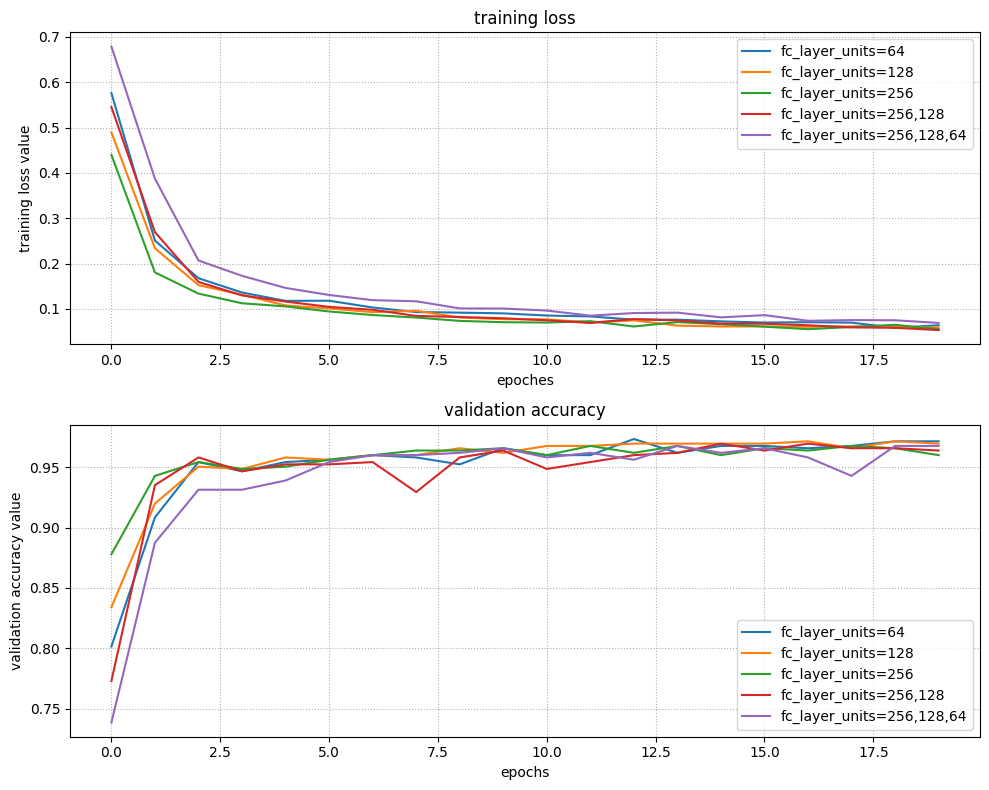

In [8]:
# fc layer tuning
from A.cnn import *
from A.preprocessing import *
import matplotlib.pyplot as plt
seed_everything(seed=42)
data = np.load('./Datasets/pneumoniamnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
xtrain, ytrain = training_data_augmentation(xtrain, ytrain)
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)
fig, ax = plt.subplots(2, 1, figsize=(10,8))
fcs = [[128*3*3, 64],
       [128*3*3, 128],
       [128*3*3, 256],
       [128*3*3, 256, 128],
       [128*3*3, 256, 128, 64]]
fclayers = ["64", "128", "256", "256,128", "256,128,64"]
for fc, fclayers in zip(fcs, fclayers):
    conv = [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
    cnn = CNN(input_channels=1, output_size=2, conv_layers=conv, fc_layers=fc, dropout_conv=0.3, dropout_fc=0.6)
    # print(cnn)
    training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=20, lr = 0.001, use_validation=True)
    ax[0].plot(training_loss, label=f'fc_layer_units={fclayers}')
    ax[0].set_xlabel("epoches")
    ax[0].set_ylabel("training loss value")
    ax[0].set_title("training loss")
    ax[0].legend()
    ax[0].grid(ls=':')
    ax[1].plot(val_accuracy, label=f'fc_layer_units={fclayers}')
    ax[1].legend()
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("validation accuracy value")
    ax[1].set_title("validation accuracy")
    ax[1].grid(ls=':')

plt.tight_layout()
plt.savefig("A/figures/fc_tuning_aug.png")

In [22]:
from A.cnn import *
from A.preprocessing import *
import matplotlib.pyplot as plt
data = np.load('./Datasets/pneumoniamnist.npz')
seed_everything(seed=42)
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
xtrain, ytrain = training_data_augmentation(xtrain, ytrain)
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)
conv = [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
fc = [128*3*3, 128]
cnn = CNN(input_channels=1, output_size=2, conv_layers=conv, fc_layers=fc, dropout_conv=0.2, dropout_fc=0.5)
# print(cnn)
training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=20, lr = 0.001, use_validation=True)

Epoch 1, Training Loss: 0.5117733563889156
Epoch 1, Validated Accuracy: 0.8320610687022901
Epoch 2, Training Loss: 0.19701277498494496
Epoch 2, Validated Accuracy: 0.9408396946564885
Epoch 3, Training Loss: 0.12238439098000527
Epoch 3, Validated Accuracy: 0.9599236641221374
Epoch 4, Training Loss: 0.10144235955720599
Epoch 4, Validated Accuracy: 0.9446564885496184
Epoch 5, Training Loss: 0.08987189275635914
Epoch 5, Validated Accuracy: 0.9637404580152672
Epoch 6, Training Loss: 0.08011916064741936
Epoch 6, Validated Accuracy: 0.9599236641221374
Epoch 7, Training Loss: 0.07554914673621005
Epoch 7, Validated Accuracy: 0.9541984732824428
Epoch 8, Training Loss: 0.06880203051153909
Epoch 8, Validated Accuracy: 0.9675572519083969
Epoch 9, Training Loss: 0.06534073194065555
Epoch 9, Validated Accuracy: 0.9561068702290076
Epoch 10, Training Loss: 0.06661301781000062
Epoch 10, Validated Accuracy: 0.9656488549618321
Epoch 11, Training Loss: 0.05892839446155863
Epoch 11, Validated Accuracy: 0.96

In [25]:
torch.save(cnn.state_dict(), 'A/Models/bestcnn_withaug.pth')

In [23]:
acc, auc = eval_cnn(cnn, test_dataloader)
print(acc, auc)

0.8717948717948718 0.9430309007232085


In [24]:
acc, auc = eval_cnn(cnn, val_dataloader)
print(acc, auc)

0.9656488549618321 0.9936589545844045


### Visualization of dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
data = np.load('./Datasets/pneumoniamnist.npz')
print(data)

for file in data.files:
    print(file)
    print(type(data[file]))
    print(data[file].shape)


train_images
<class 'numpy.ndarray'>
(4708, 28, 28)
val_images
<class 'numpy.ndarray'>
(524, 28, 28)
test_images
<class 'numpy.ndarray'>
(624, 28, 28)
train_labels
<class 'numpy.ndarray'>
(4708, 1)
val_labels
<class 'numpy.ndarray'>
(524, 1)
test_labels
<class 'numpy.ndarray'>
(624, 1)


In [3]:
xtrain = data["train_images"]
ytrain = data["train_labels"]
xval = data["val_images"]
yval = data["val_labels"]
xtest = data["test_images"]
ytest = data["test_labels"]
data.close()

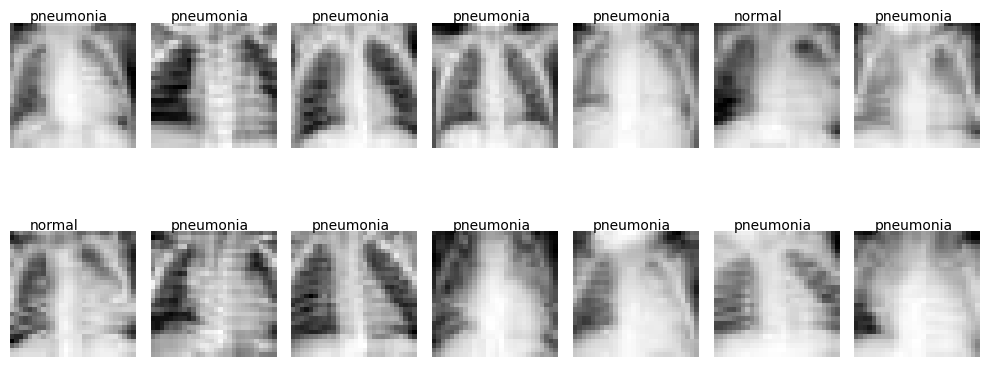

In [9]:
plt.figure(figsize=(10,5))
for i in range(14):
    plt.subplot(2,7,i+1)
    plt.imshow(xtest[i], cmap='gray')
    plt.axis("off")
    plt.text(4, -1, "normal" if ytrain[i]==0 else "pneumonia")
plt.tight_layout()

### CNN hyperparameter tuning

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [7]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
seed_everything(seed=42)

In [9]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_layers, fc_layers, pool_size=2, activation_func=F.relu, dropout_conv=0.0, dropout_fc=0.0):
        """
        A CNN network with configurable hyperparameters

        Args:
        - input_channels (int): channel num of input image
        - conv_layers (list of tuples): a list of conv layer configs, each element (num_filters, kernel_size, stride, padding)
        - fc_layers (list of tuples): a list of fc layer configs, each element (input_unit, output_unit), must match the output of conv layers
        - pool_size (int): the size of pooling kernel
        - activation_func : the activation function chosen from (F.relu, torch.sigmoid, torch.tanh, etc.)
        - dropout_conv : the dropout ratio of convolutional layer
        - dropout_fc : the dropout ratio of fully connected layer
        """
        super(CNN, self).__init__()
        self.pool_size = pool_size
        self.activation_func = activation_func
        
        self.conv_layers = nn.ModuleList()
        self.conv_dropout_layers = nn.ModuleList()
        for i, (out_channels, kernel_size, stride, padding) in enumerate(conv_layers):
            if i == 0:
                in_channels = input_channels
            else:
                in_channels = conv_layers[i-1][0]
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
            self.conv_dropout_layers.append(nn.Dropout2d(dropout_conv))

        self.fc_layers = nn.ModuleList()
        self.fc_dropout_layers = nn.ModuleList()
        for (in_unit, out_unit) in fc_layers:
            # must match conv layer output
            self.fc_layers.append(nn.Linear(in_unit, out_unit))
            self.fc_dropout_layers.append(nn.Dropout(dropout_fc))


    def forward(self, x):
        for conv_layer, dropout_layer in zip(self.conv_layers, self.conv_dropout_layers):
            x = dropout_layer(self.activation_func(F.max_pool2d(conv_layer(x), self.pool_size)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        for fc_layer, dropout_layer in zip(self.fc_layers, self.fc_dropout_layers):
            x = dropout_layer(self.activation_func(fc_layer(x)))
        return x

In [10]:
conv = [(16, 3, 1, 1), (32, 3, 1, 1)]
fc = [(32*7*7, 128), (128, 2)]
cnn = CNN(input_channels=1, conv_layers=conv, fc_layers=fc, dropout_conv=0.2, dropout_fc=0.5)

In [11]:
xtrain_norm = xtrain/255.0
xval_norm = xval/255.0
xtest_norm = xtest/255.0

In [12]:
generator = torch.Generator()
xtrain_tensor = torch.tensor(xtrain_norm, dtype=torch.float32).unsqueeze(1) # add a channel
ytrain_tensor = torch.tensor(ytrain, dtype=torch.long).squeeze()
train_dataset = TensorDataset(xtrain_tensor, ytrain_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)

xval_tensor = torch.tensor(xval_norm, dtype=torch.float32).unsqueeze(1) # add a channel
yval_tensor = torch.tensor(yval, dtype=torch.long).squeeze()
val_dataset = TensorDataset(xval_tensor, yval_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, generator=generator)

In [13]:
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
for epoch in range(epochs):
    cnn.train()
    for images, labels in train_dataloader:
        #print(images.shape)
        output = cnn(images) # forward
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.49832862615585327
Epoch 2, Loss: 0.478467732667923
Epoch 3, Loss: 0.553040623664856
Epoch 4, Loss: 0.6313750743865967
Epoch 5, Loss: 0.5205729603767395
Epoch 6, Loss: 0.48074790835380554
Epoch 7, Loss: 0.46630048751831055
Epoch 8, Loss: 0.46551433205604553
Epoch 9, Loss: 0.48484742641448975
Epoch 10, Loss: 0.5204240679740906
Epoch 11, Loss: 0.5423270463943481
Epoch 12, Loss: 0.5415340662002563
Epoch 13, Loss: 0.3882492780685425
Epoch 14, Loss: 0.29109323024749756
Epoch 15, Loss: 0.37472569942474365
Epoch 16, Loss: 0.44080421328544617
Epoch 17, Loss: 0.5708435773849487
Epoch 18, Loss: 0.33098968863487244
Epoch 19, Loss: 0.3664064407348633
Epoch 20, Loss: 0.4477037787437439
Epoch 21, Loss: 0.36292529106140137
Epoch 22, Loss: 0.32283782958984375
Epoch 23, Loss: 0.41939830780029297
Epoch 24, Loss: 0.45985037088394165
Epoch 25, Loss: 0.34622272849082947
Epoch 26, Loss: 0.34813472628593445
Epoch 27, Loss: 0.3928212821483612
Epoch 28, Loss: 0.2524469196796417
Epoch 29, Loss: 

In [14]:
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        output = cnn(images)
        _, predict = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()

print(f"accuracy: {correct/total*100}%")

accuracy: 96.56488549618321%


### KNN

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

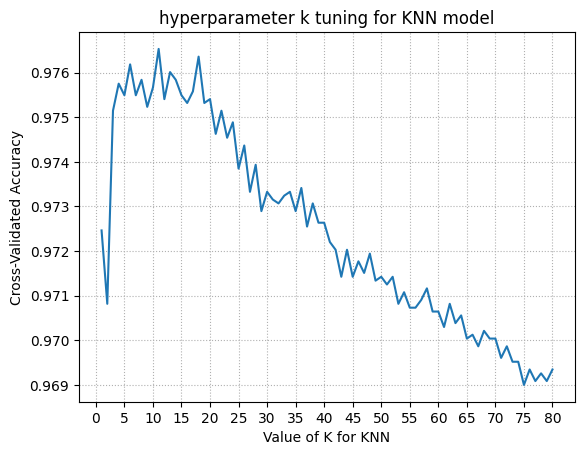

In [5]:
from A.preprocessing import *
from A.knn import KNN_k_tuning_plot
xtrain, ytrain = training_data_augmentation(xtrain, ytrain)
xtrain_new, ytrain_new, xval_new, yval_new, xtest_new, ytest_new = preprocessing_KNN_SVM(xtrain, ytrain, xval, yval, xtest, ytest)
KNN_k_tuning_plot(xtrain_new, ytrain_new)

In [9]:
from A.knn import KNN_tuning, KNN_tuning_results_plot
import pandas as pd
param_grid = {
    'n_neighbors': [5, 10, 15, 20, 25], 
    'metric': ['cosine', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}
best_classifier, best_params, cv_results = KNN_tuning(param_grid, xtrain_new, ytrain_new)

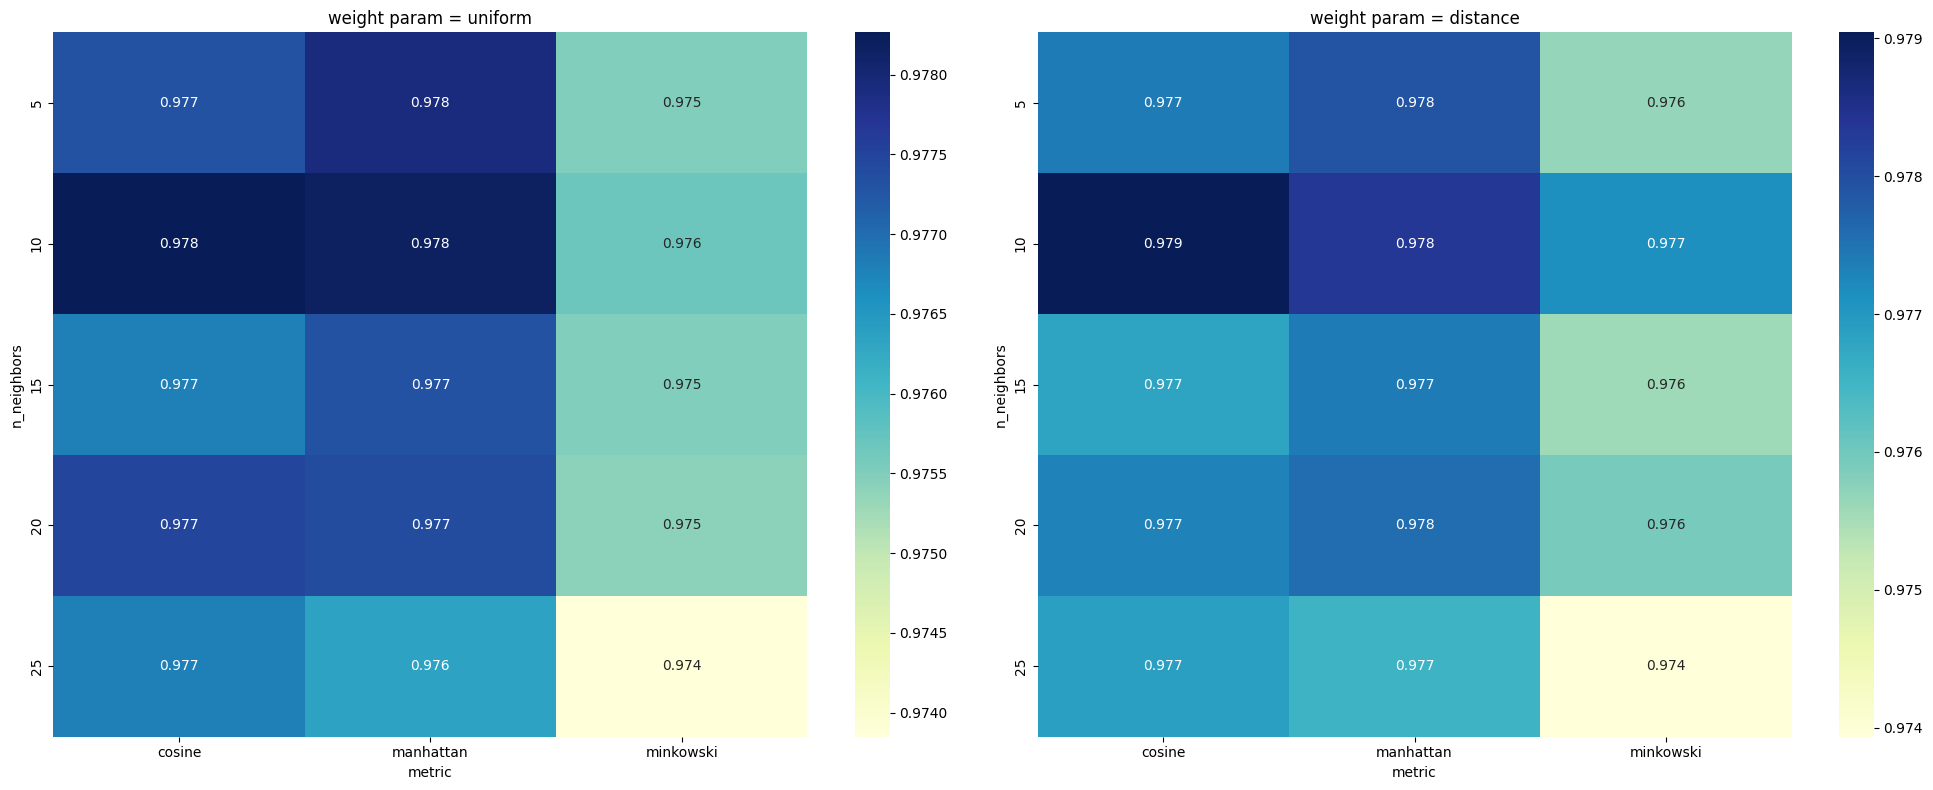

In [10]:
KNN_tuning_results_plot(cv_results)

In [11]:
print(best_params)

{'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}


In [12]:
best_classifier.fit(xtrain_new, ytrain_new)
accuracy = accuracy_score(yval_new, best_classifier.predict(xval_new))
print(accuracy)
accuracy = accuracy_score(ytest_new, best_classifier.predict(xtest_new))
print(accuracy)

0.9522900763358778
0.8285256410256411


In [3]:
print(xtrain.shape)
print(xval.shape)

(4708, 28, 28)
(524, 28, 28)


In [2]:
def preprocess_KNN(xtrain, ytrain, xval, yval, xtest, ytest):
    """preprocessing for knn
    xtrain: nx28x28 -> nx784
    ytrain: nx1 -> n,
    """
    n_train, n_val, n_test = len(xtrain), len(xval), len(xtest)
    xtrain_knn = xtrain.reshape((n_train,-1))
    xval_knn = xval.reshape((n_val,-1))
    xtest_knn= xtest.reshape((n_test,-1))
    ytrain_knn = ytrain.ravel()
    yval_knn = yval.ravel()
    ytest_knn = ytest.ravel()

    return xtrain_knn, ytrain_knn, xval_knn, yval_knn, xtest_knn, ytest_knn

In [3]:
xtrain_knn, ytrain_knn, xval_knn, yval_knn, xtest_knn, ytest_knn = preprocess_KNN(xtrain, ytrain, xval, yval, xtest, ytest)
print(xtrain_knn.shape)
print(xval_knn.shape)
print(xtest_knn.shape)

(4708, 784)
(524, 784)
(624, 784)


In [9]:
def KNN(xtrain, ytrain, xtest, ytest, k=68):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    y_pred = knn.predict(xtest)
    y_prob = knn.predict_proba(xtest)[:,1]
    accuracy = accuracy_score(ytest, y_pred)
    auc = roc_auc_score(ytest, y_prob)
    return accuracy, auc

In [10]:
acc_score, auc = KNN(xtrain_knn, ytrain_knn, xval_knn, yval_knn)
print(acc_score)
print(auc)
acc_score, auc = KNN(xtrain_knn, ytrain_knn, xtest_knn, ytest_knn)
print(acc_score)
print(auc)

0.9408396946564885
0.9824526325811672
0.8092948717948718
0.9316951566951567


In [4]:
from A.knn import KNN_k_tuning_plot

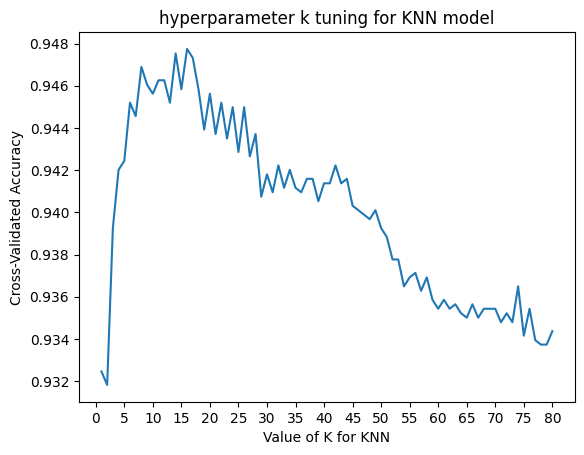

In [5]:
KNN_k_tuning_plot(xtrain_knn, ytrain_knn)

In [11]:
import pandas as pd
param_grid = {
    'n_neighbors': [5, 10, 15, 25, 40, 70], 
    'metric': ['cosine', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}
# best_model, best_param = KNN_tuning(param_grid, xtrain_knn, ytrain_knn)
# print(best_param)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(xtrain_knn, ytrain_knn)
best_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_
result = grid_search.cv_results_

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

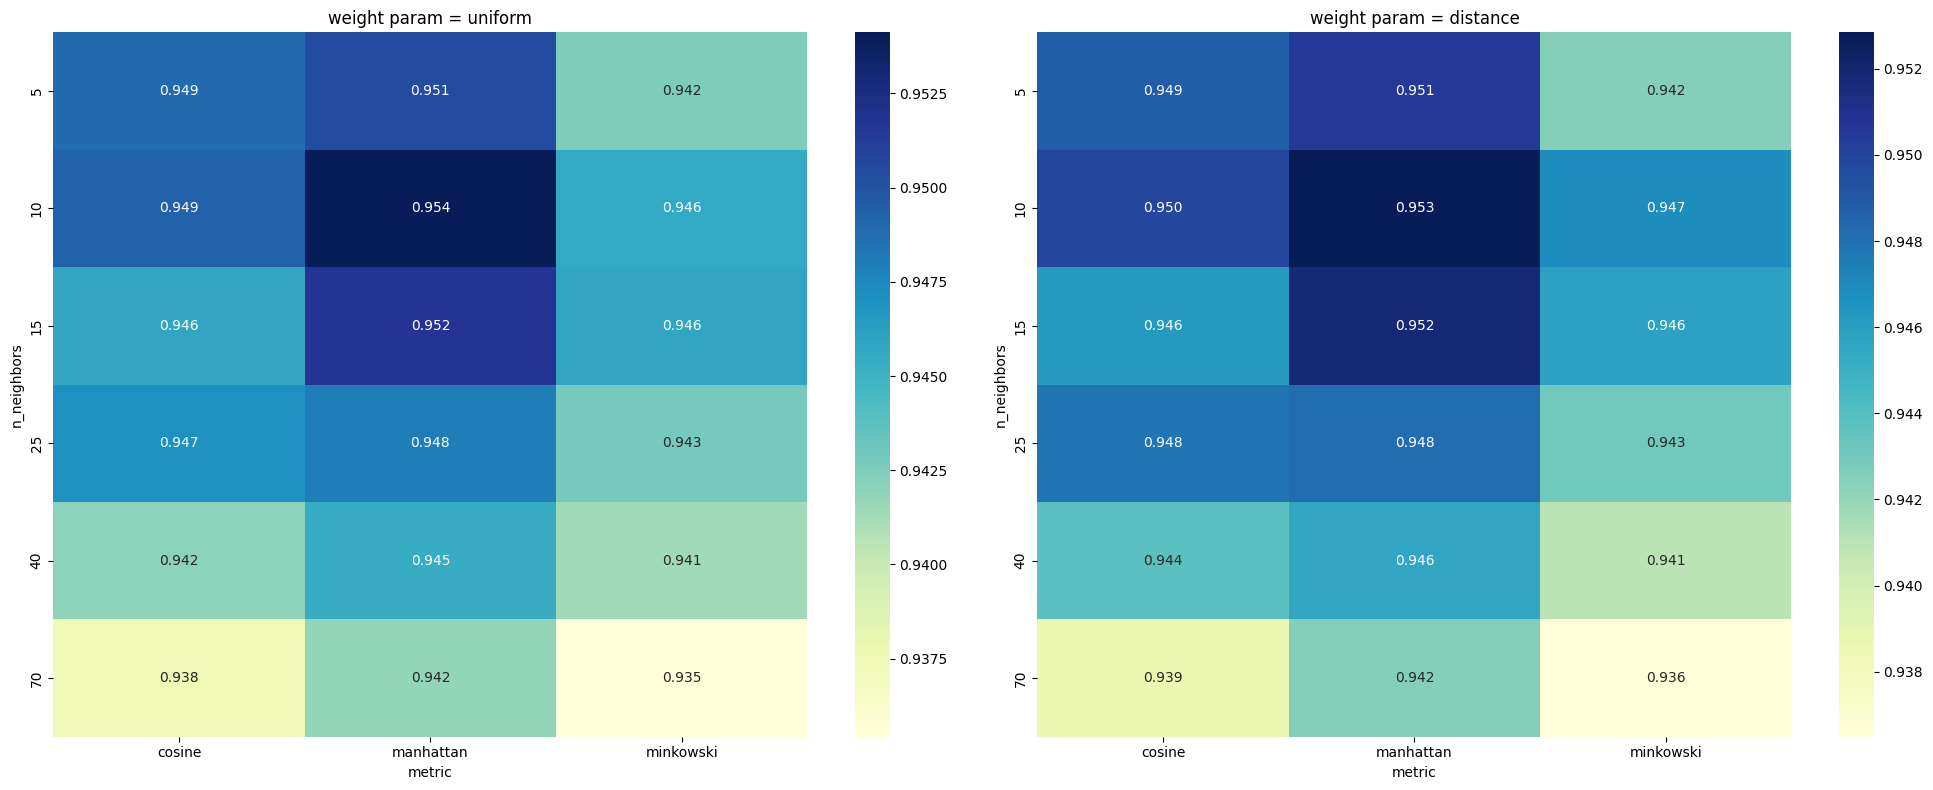

In [29]:
df = pd.DataFrame(result)
weight_values = df['param_weights'].unique()
num_weights = len(weight_values)
fig, ax = plt.subplots(1, num_weights, figsize=(20, 8))
for i, weight in enumerate(weight_values):
    df_sub = df[df['param_weights']==weight]
    piv_sub = df_sub.pivot(index='param_n_neighbors', columns='param_metric', values='mean_test_score')
    sns.heatmap(piv_sub,annot=True, fmt=".3f", cmap="YlGnBu",  ax=ax[i])
    ax[i].set_title(f"weight param = {weight}")
    ax[i].set_xlabel("metric")
    ax[i].set_ylabel("n_neighbors")
plt.tight_layout()
plt.savefig("./A/figures/KNN_hyperparamter_heatmap")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))


### SVM

In [3]:
# preprocessing
from A.preprocessing import preprocessing_KNN_SVM, training_data_augmentation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
augmented_xtrain, augmented_ytrain = training_data_augmentation(xtrain, ytrain)
#xtrain_svm, ytrain_svm, xval_svm, yval_svm, xtest_svm, ytest_svm = preprocessing_KNN_SVM(xtrain, ytrain, xval, yval, xtest, ytest)
xtrain_svm, ytrain_svm, xval_svm, yval_svm, xtest_svm, ytest_svm = preprocessing_KNN_SVM(augmented_xtrain, augmented_ytrain, xval, yval, xtest, ytest)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from A.svm import SVM_C_tuning_plot

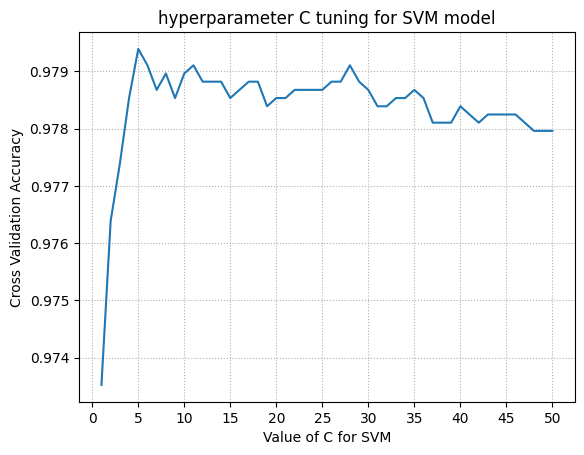

In [4]:
SVM_C_tuning_plot(xtrain_svm, ytrain_svm, xval_svm, yval_svm)

In [5]:
from A.svm import SVM_tuning
param_grid = {
    'C':[5, 15, 30, 40],
    'gamma':['scale','auto', 0.001, 0.0001],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
best_classifier, best_params, cv_results = SVM_tuning(param_grid, xtrain_svm, ytrain_svm)

In [6]:
best_params

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

In [7]:
best_classifier.fit(xtrain_svm, ytrain_svm)
accuracy = accuracy_score(yval_svm, best_classifier.predict(xval_svm))
print(accuracy)
accuracy = accuracy_score(ytest_svm, best_classifier.predict(xtest_svm))
print(accuracy)

0.9656488549618321
0.8621794871794872


In [7]:
C=0.8
kernel = 'rbf'
svm = SVC(C=C, kernel=kernel, gamma='scale', probability=True)
svm.fit(xtrain_svm, ytrain_svm)
print(accuracy_score(yval_svm, svm.predict(xval_svm)))
print(classification_report(yval_svm, svm.predict(xval_svm)))
print(accuracy_score(ytest_svm, svm.predict(xtest_svm)))
print(roc_auc_score(ytest_svm, svm.predict_proba(xtest_svm)[:,1]))
# print(classification_report(ytest_knn, svm.predict(xtest_knn)))

0.9599236641221374
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       135
           1       0.96      0.98      0.97       389

    accuracy                           0.96       524
   macro avg       0.95      0.94      0.95       524
weighted avg       0.96      0.96      0.96       524

0.8701923076923077
0.9412776682007451


In [10]:
# tune C
c_range = list(range(1, 51))
scores = []
accuracy = []
for C in range(1, 51):
    svm = SVC(C=C, kernel='rbf', probability=True)
    svm.fit(xtrain_svm, ytrain_svm)
    score = cross_val_score(svm, xtrain_svm, ytrain_svm, cv=5, scoring='accuracy')
    acc = accuracy_score(yval_svm, svm.predict(xval_svm))
    scores.append(score.mean())
    accuracy.append(acc)

In [13]:
print(scores)

[0.9662278237679119, 0.9692022535541762, 0.9700515104543885, 0.9700510592020505, 0.9692018023018381, 0.9685644083743409, 0.9694145677792292, 0.9696268820042823, 0.9692024791803453, 0.968777850730239, 0.9694152446577362, 0.9694150190315675, 0.9696273332566203, 0.9694150190315675, 0.9689901649552922, 0.9689901649552922, 0.968565085252848, 0.968565085252848, 0.9683525454016259, 0.9681402311765727, 0.9683527710277948, 0.9683527710277948, 0.9681404568027417, 0.9681404568027417, 0.9681402311765728, 0.9681402311765728, 0.9681404568027417, 0.9681404568027417, 0.9681402311765728, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.9683527710277948, 0.

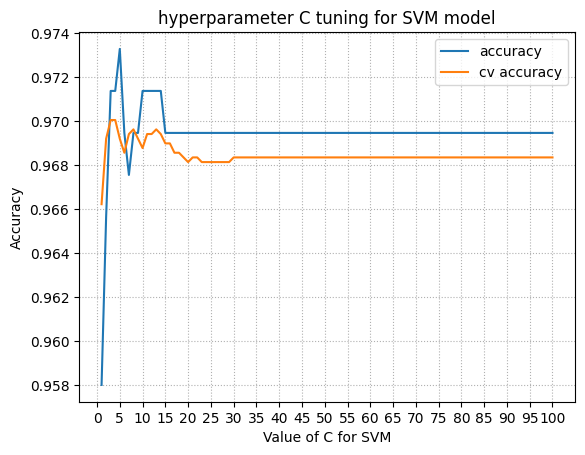

In [11]:
plt.plot(c_range, accuracy, label='validation accuracy')
plt.plot(c_range, scores, label='cv accuracy score')
plt.xlabel('Value of C for SVM')
plt.ylabel('Accuracy')
plt.title('hyperparameter C tuning for SVM model')
plt.xticks(range(0,101,5))
plt.legend()
plt.grid(ls=':')
plt.savefig("A/figures/SVM_C_tuning_plot.png")

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = {
    'C':[3, 5, 10, 15],
    'gamma':['scale','auto', 0.001, 0.0001],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(xtrain_svm, ytrain_svm) #not eval on val set
print(grid_search.cv_results_)

{'mean_fit_time': array([0.69424644, 0.5986815 , 1.50327678, 0.57716336, 2.94796829,
       1.46165442, 0.62066002, 3.21104078, 1.45859861, 0.59165254,
       3.2518755 , 1.47901974, 0.59940009, 0.51352844, 1.64679217,
       0.60962667, 3.3737813 , 1.56303916, 0.6562892 , 3.46259575,
       1.4047008 , 0.59179435, 2.90987382, 1.37117372, 0.57420568,
       0.48391204, 1.47666478, 0.60609207, 3.85564122, 1.3385313 ,
       0.57465529, 3.39776216, 1.53994546, 0.59585037, 3.10499482,
       1.58661122, 0.61606421, 0.55988708, 1.6156177 , 0.56178737,
       2.84872937, 1.3457448 , 0.54002047, 2.95053797, 1.28052654,
       0.54243875, 3.03289065, 2.75255814]), 'std_fit_time': array([0.06217495, 0.05800677, 0.054622  , 0.04351297, 0.01167718,
       0.04294989, 0.05435106, 0.05691673, 0.03259853, 0.04072984,
       0.15358544, 0.03451524, 0.03664293, 0.01109237, 0.06334297,
       0.02394527, 0.16987194, 0.08775225, 0.06871731, 0.05500914,
       0.07852822, 0.02987972, 0.09018978, 0.02334

In [16]:
print(grid_search.best_params_)

{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [8]:
best_svm = SVC(C=3, gamma='scale', kernel='rbf', probability=True)
best_svm.fit(xtrain_svm, ytrain_svm)
print(accuracy_score(yval_svm, best_svm.predict(xval_svm)))
print(roc_auc_score(yval_svm, best_svm.predict_proba(xval_svm)[:,1]))
print(classification_report(yval_svm, best_svm.predict(xval_svm)))

0.9713740458015268
0.9950490336094449
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       135
           1       0.97      0.99      0.98       389

    accuracy                           0.97       524
   macro avg       0.97      0.96      0.96       524
weighted avg       0.97      0.97      0.97       524



In [9]:
print(accuracy_score(ytest_svm, best_svm.predict(xtest_svm)))
print(roc_auc_score(ytest_svm, best_svm.predict_proba(xtest_svm)[:,1]))
print(classification_report(ytest_svm, best_svm.predict(xtest_svm)))

0.8541666666666666
0.9420008766162612
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       234
           1       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.85      0.85       624



### Task B

In [1]:
import numpy as np
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()

In [2]:
print(xtrain.shape)

(89996, 28, 28, 3)


In [2]:
from B.preprocessing import *

In [3]:
#xtrain_new, ytrain_new, xval_new, yval_new, xtest_new, ytest_new = preprocessing_feature_extraction(xtrain, ytrain, xval, yval, xtest, ytest)
#xtrain_new, ytrain_new, xval_new, yval_new, xtest_new, ytest_new = preprocessing_no_extraction(xtrain, ytrain, xval, yval, xtest, ytest)
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)
# print(xtrain_new.shape, xval_new.shape, xtest_new.shape)

### CNN

In [1]:
from B.cnn import *
import matplotlib.pyplot as plt
import numpy as np
from B.preprocessing import *
seed_everything()
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)

Epoch 1, Training Loss: 2.1863733539364403
Epoch 1, Validated Accuracy: 0.14314274290283888
Epoch 2, Training Loss: 2.185612820358927
Epoch 2, Validated Accuracy: 0.14314274290283888
Epoch 3, Training Loss: 2.1856816977410767
Epoch 3, Validated Accuracy: 0.14314274290283888
Epoch 4, Training Loss: 2.1856242729233104
Epoch 4, Validated Accuracy: 0.14314274290283888
Epoch 5, Training Loss: 2.1855971108282723
Epoch 5, Validated Accuracy: 0.14314274290283888
Epoch 6, Training Loss: 2.1855049360366094
Epoch 6, Validated Accuracy: 0.14314274290283888
Epoch 7, Training Loss: 2.18568698446549
Epoch 7, Validated Accuracy: 0.14314274290283888
Epoch 8, Training Loss: 2.1857009610133384
Epoch 8, Validated Accuracy: 0.14314274290283888
Epoch 9, Training Loss: 2.185583004819305
Epoch 9, Validated Accuracy: 0.13534586165533785
Epoch 10, Training Loss: 2.1854995352711843
Epoch 10, Validated Accuracy: 0.13534586165533785
Epoch 11, Training Loss: 2.1856581181944392
Epoch 11, Validated Accuracy: 0.143142

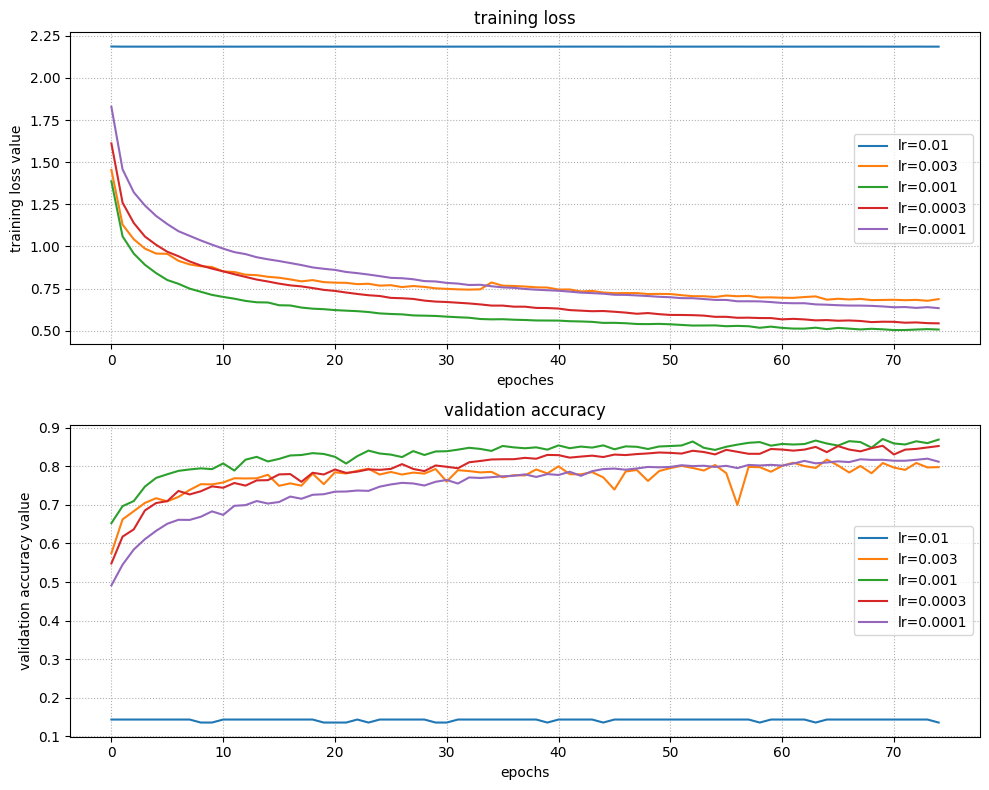

In [2]:
from B.cnn import lr_tuning
lr_tuning(train_dataloader, val_dataloader)

Epoch 1, Training Loss: 1.6758670097305661
Epoch 1, Validated Accuracy: 0.5566773290683726
Epoch 2, Training Loss: 1.343600112830991
Epoch 2, Validated Accuracy: 0.5886645341863255
Epoch 3, Training Loss: 1.2325219210361706
Epoch 3, Validated Accuracy: 0.6299480207916833
Epoch 4, Training Loss: 1.1728998272657902
Epoch 4, Validated Accuracy: 0.6536385445821671
Epoch 5, Training Loss: 1.1386737817555517
Epoch 5, Validated Accuracy: 0.6672331067572971
Epoch 6, Training Loss: 1.107440512571762
Epoch 6, Validated Accuracy: 0.6729308276689324
Epoch 7, Training Loss: 1.0917021111977718
Epoch 7, Validated Accuracy: 0.6764294282287086
Epoch 8, Training Loss: 1.0760073436857032
Epoch 8, Validated Accuracy: 0.6831267493002798
Epoch 9, Training Loss: 1.0621184567737512
Epoch 9, Validated Accuracy: 0.6909236305477809
Epoch 10, Training Loss: 1.0509728785516865
Epoch 10, Validated Accuracy: 0.6732307077169132
Epoch 11, Training Loss: 1.0397585943055305
Epoch 11, Validated Accuracy: 0.67283086765293

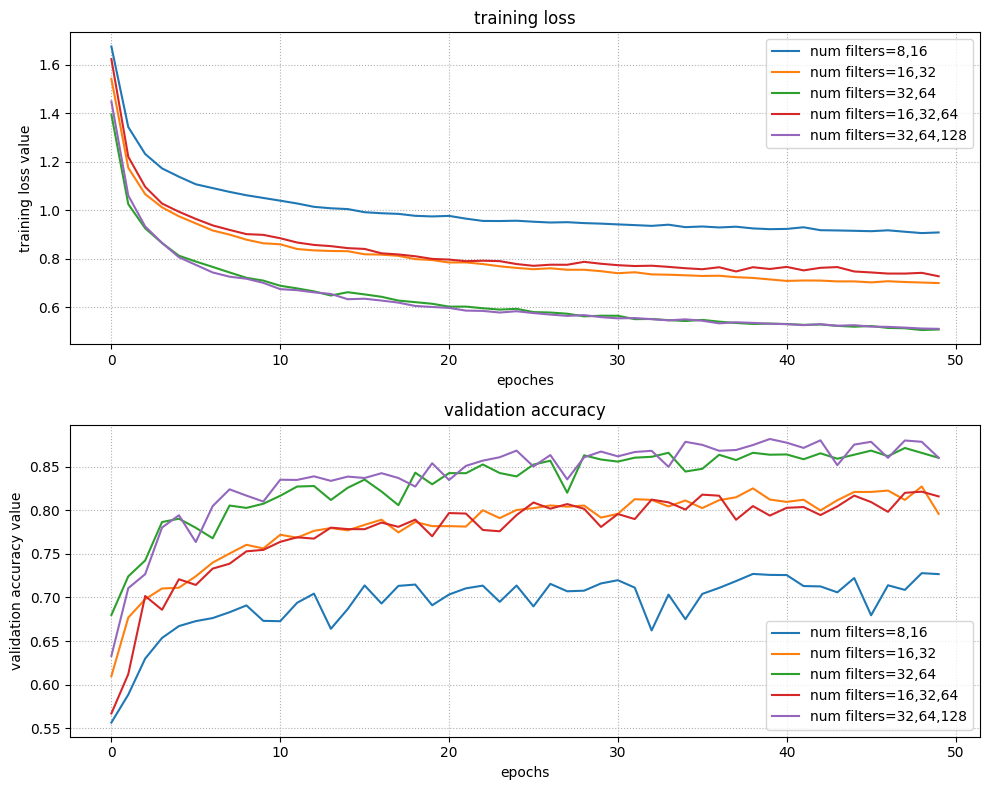

In [3]:
from B.cnn import conv_layer_tuning
conv_layer_tuning(train_dataloader, val_dataloader)

Epoch 1, Training Loss: 2.1865025768063133
Epoch 1, Validated Accuracy: 0.14314274290283888
Epoch 2, Training Loss: 2.185691038598045
Epoch 2, Validated Accuracy: 0.14314274290283888
Epoch 3, Training Loss: 2.1856125673674995
Epoch 3, Validated Accuracy: 0.14314274290283888


KeyboardInterrupt: 

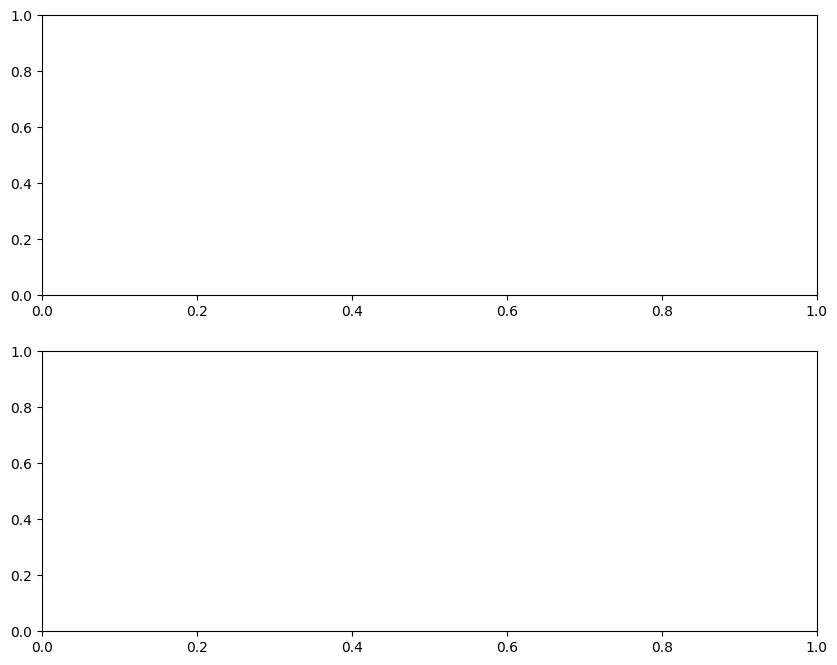

In [3]:
# lr tuning
lrs = [0.01, 0.003, 0.001, 0.0003, 0.0001]
fig, ax = plt.subplots(2, 1, figsize=(10,8))
for lr in lrs:
    conv = [(16, 3, 1, 1), (32, 3, 1, 1)]
    fc = [32*7*7, 128]
    cnn = CNN(input_channels=3, output_size=9, conv_layers=conv, fc_layers=fc, dropout_conv=0.3, dropout_fc=0.6)
    # print(cnn)
    training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=75, lr = lr, use_validation=True)
    ax[0].plot(training_loss, label=f'lr={lr}')
    ax[0].set_xlabel("epoches")
    ax[0].set_ylabel("training loss value")
    ax[0].set_title("training loss")
    ax[0].legend()
    ax[0].grid(ls=':')
    ax[1].plot(val_accuracy, label=f'lr={lr}')
    ax[1].legend()
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("validation accuracy value")
    ax[1].set_title("validation accuracy")
    ax[1].grid(ls=':')

plt.tight_layout()
plt.savefig("B/figures/lr_tuning.png")

Epoch 1, Training Loss: 1.549021763926969
Epoch 1, Validated Accuracy: 0.5535785685725709
Epoch 2, Training Loss: 1.194291560804073
Epoch 2, Validated Accuracy: 0.6498400639744102
Epoch 3, Training Loss: 1.0935412539009008
Epoch 3, Validated Accuracy: 0.6537385045981607
Epoch 4, Training Loss: 1.036907026889736
Epoch 4, Validated Accuracy: 0.6774290283886445
Epoch 5, Training Loss: 1.0037686853605376
Epoch 5, Validated Accuracy: 0.6411435425829668
Epoch 6, Training Loss: 0.9761399951231928
Epoch 6, Validated Accuracy: 0.6877249100359856
Epoch 7, Training Loss: 0.9532159492320513
Epoch 7, Validated Accuracy: 0.6357457017193123
Epoch 8, Training Loss: 0.9411353887017093
Epoch 8, Validated Accuracy: 0.6670331867253099
Epoch 9, Training Loss: 0.9196440509726328
Epoch 9, Validated Accuracy: 0.6844262295081968
Epoch 10, Training Loss: 0.9030357047693053
Epoch 10, Validated Accuracy: 0.6652339064374251
Epoch 11, Training Loss: 0.8942587300234851
Epoch 11, Validated Accuracy: 0.701919232307077

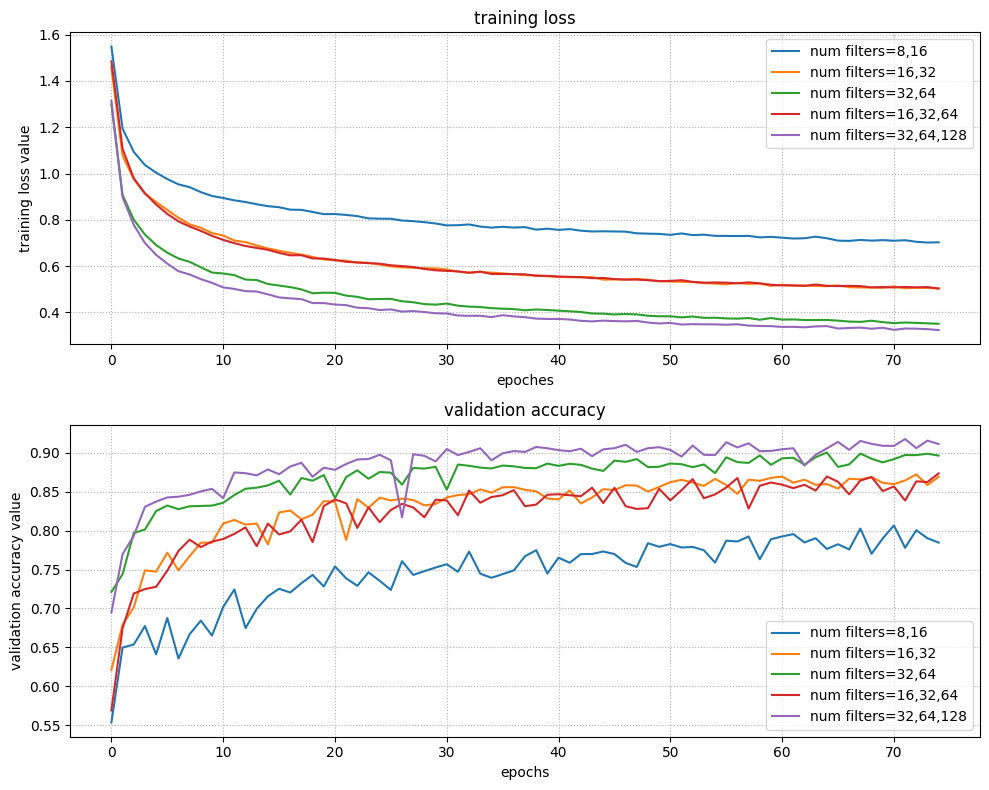

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
convs = [[(8, 3, 1, 1), [16, 3, 1, 1]],
         [(16, 3, 1, 1), (32, 3, 1, 1)], 
         [(32, 3, 1, 1), (64, 3, 1, 1)], 
         [(16, 3, 1, 1), (32, 3, 1, 1), (64, 3, 1, 1)], 
         [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]]
fcs = [[16*7*7, 128],
       [32*7*7, 128], 
       [64*7*7, 128],
       [64*3*3, 128],
       [128*3*3, 128]]
filters = ["8,16", "16,32", "32,64", "16,32,64", "32,64,128"]
for conv, fc, filter in zip(convs, fcs, filters):
    cnn = CNN(input_channels=3, output_size=9, conv_layers=conv, fc_layers=fc, dropout_conv=0.2, dropout_fc=0.5)
    training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=75, lr = 0.001, use_validation=True)
    ax[0].plot(training_loss, label=f'num filters={filter}')
    ax[0].set_xlabel("epoches")
    ax[0].set_ylabel("training loss value")
    ax[0].set_title("training loss")
    ax[0].legend()
    ax[0].grid(ls=':')
    ax[1].plot(val_accuracy, label=f'num filters={filter}')
    ax[1].legend()
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("validation accuracy value")
    ax[1].set_title("validation accuracy")
    ax[1].grid(ls=':')

plt.tight_layout()
plt.savefig("B/figures/conv_tuning.png")

Epoch 1, Training Loss: 1.3351437416412175
Epoch 1, Validated Accuracy: 0.6128548580567773
Epoch 2, Training Loss: 0.9720262595754866
Epoch 2, Validated Accuracy: 0.7433026789284286
Epoch 3, Training Loss: 0.8483547303976535
Epoch 3, Validated Accuracy: 0.7735905637744902
Epoch 4, Training Loss: 0.7739074389690529
Epoch 4, Validated Accuracy: 0.7620951619352259
Epoch 5, Training Loss: 0.7203993122037117
Epoch 5, Validated Accuracy: 0.8029788084766094
Epoch 6, Training Loss: 0.6818422937994743
Epoch 6, Validated Accuracy: 0.821671331467413
Epoch 7, Training Loss: 0.640388630409993
Epoch 7, Validated Accuracy: 0.8341663334666134
Epoch 8, Training Loss: 0.6159425747621203
Epoch 8, Validated Accuracy: 0.8396641343462615
Epoch 9, Training Loss: 0.5926299410969463
Epoch 9, Validated Accuracy: 0.8617552978808477
Epoch 10, Training Loss: 0.5703405851621364
Epoch 10, Validated Accuracy: 0.8563574570171931
Epoch 11, Training Loss: 0.5583525126549735
Epoch 11, Validated Accuracy: 0.83876449420231

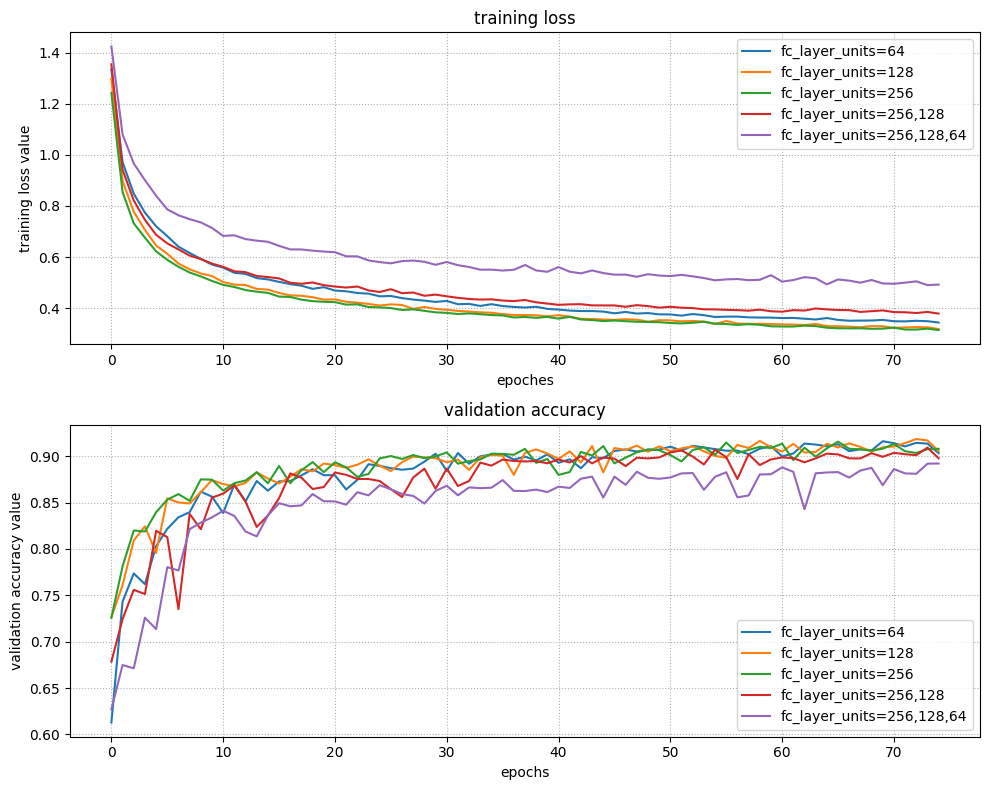

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
fcs = [[128*3*3, 64],
       [128*3*3, 128],
       [128*3*3, 256],
       [128*3*3, 256, 128],
       [128*3*3, 256, 128, 64]]
fclayers = ["64", "128", "256", "256,128", "256,128,64"]
for fc, fclayers in zip(fcs, fclayers):
    conv = [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
    cnn = CNN(input_channels=3, output_size=9, conv_layers=conv, fc_layers=fc, dropout_conv=0.2, dropout_fc=0.5)
    # print(cnn)
    training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader=val_dataloader, epochs=75, lr = 0.001, use_validation=True)
    ax[0].plot(training_loss, label=f'fc_layer_units={fclayers}')
    ax[0].set_xlabel("epoches")
    ax[0].set_ylabel("training loss value")
    ax[0].set_title("training loss")
    ax[0].legend()
    ax[0].grid(ls=':')
    ax[1].plot(val_accuracy, label=f'fc_layer_units={fclayers}')
    ax[1].legend()
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("validation accuracy value")
    ax[1].set_title("validation accuracy")
    ax[1].grid(ls=':')

plt.tight_layout()
plt.savefig("B/figures/fc_tuning.png")

In [4]:
from B.cnn import *
import matplotlib.pyplot as plt
import numpy as np
from B.preprocessing import *
seed_everything(seed=42)
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
train_dataloader, val_dataloader, test_dataloader = preprocessing_CNN(xtrain, ytrain, xval, yval, xtest, ytest)
conv = [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
fc = [128*3*3, 256]
cnn = CNN(input_channels=3, output_size=9, conv_layers=conv, fc_layers=fc, dropout_conv=0.2, dropout_fc=0.5)
training_loss, val_accuracy = train_cnn(cnn, train_dataloader, val_dataloader, epochs=75, lr = 0.001, use_validation=False)
# cnn.load_state_dict(torch.load("B/Models/cnn.pth"))
# cnn.to("cuda")

Epoch 1, Training Loss: 1.239378835939734
Epoch 2, Training Loss: 0.8637182404576419
Epoch 3, Training Loss: 0.7504912747841993
Epoch 4, Training Loss: 0.6634512631793181
Epoch 5, Training Loss: 0.6154633308227976
Epoch 6, Training Loss: 0.5763206412670201
Epoch 7, Training Loss: 0.543274096323822
Epoch 8, Training Loss: 0.5284492451837915
Epoch 9, Training Loss: 0.5103347123347027
Epoch 10, Training Loss: 0.49856438418398874
Epoch 11, Training Loss: 0.48349485643255685
Epoch 12, Training Loss: 0.47396918903578233
Epoch 13, Training Loss: 0.46134763975133264
Epoch 14, Training Loss: 0.4534246959665945
Epoch 15, Training Loss: 0.44835385840118736
Epoch 16, Training Loss: 0.43600109842286183
Epoch 17, Training Loss: 0.4304610040480987
Epoch 18, Training Loss: 0.4256808423856174
Epoch 19, Training Loss: 0.41728571381660834
Epoch 20, Training Loss: 0.4161017940200299
Epoch 21, Training Loss: 0.4093731711562339
Epoch 22, Training Loss: 0.40929414634807953
Epoch 23, Training Loss: 0.39753131

In [27]:
torch.save(cnn.state_dict(), 'B/Models/bestcnn.pth')

In [5]:
accuracy, auc = eval_cnn(cnn, test_dataloader)
print(accuracy)
print(auc)

0.8381615598885794
0.9214594367132906


In [6]:
accuracy, auc = eval_cnn(cnn, val_dataloader)
print(accuracy)
print(auc)

0.9083366653338665
0.9809684260282526


### SVM

In [6]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(xtrain_new, ytrain_new)

### KNN

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [9]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(xtrain_new, ytrain_new)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [10]:
acc = accuracy_score(yval_new, knn.predict(xval_new))
classification_report(yval_new, knn.predict(xval_new))

'              precision    recall  f1-score   support\n\n           0       0.85      0.87      0.86      1041\n           1       0.39      0.92      0.55      1057\n           2       0.29      0.67      0.40      1152\n           3       0.75      0.39      0.52      1156\n           4       0.43      0.24      0.31       890\n           5       0.45      0.36      0.40      1354\n           6       0.49      0.09      0.15       877\n           7       0.30      0.08      0.13      1045\n           8       0.62      0.49      0.54      1432\n\n    accuracy                           0.47     10004\n   macro avg       0.51      0.46      0.43     10004\nweighted avg       0.51      0.47      0.44     10004\n'

### adaboost

In [12]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(xtrain_new, ytrain_new)
print(accuracy_score(yval_new, ada.predict(xval_new)))

0.499000399840064


### random forest

In [1]:
import numpy as np
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()

[ 9366  9509 10360 10401  8006 12182  7886  9401 12885]


<BarContainer object of 9 artists>

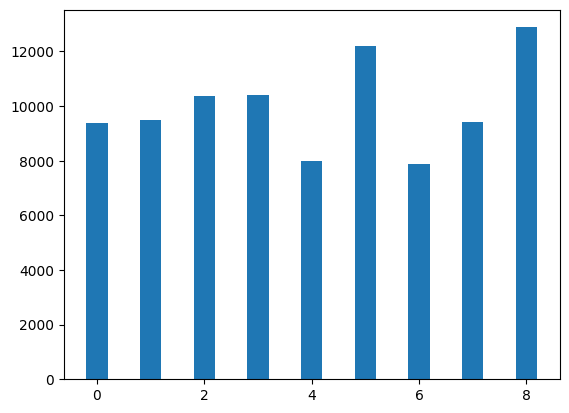

In [3]:
import matplotlib.pyplot as plt
values, counts = np.unique(ytrain, return_counts=True)
print(counts)
plt.bar(values, counts, width=0.4)

In [9]:
from B.preprocessing import *
xtrain_new, ytrain_new, xval_new, yval_new, xtest_new, ytest_new = preprocessing_feature_extraction(xtrain, ytrain, xval, yval, xtest, ytest)
#xtrain_new, ytrain_new, xval_new, yval_new, xtest_new, ytest_new = preprocessing_no_extraction(xtrain, ytrain, xval, yval, xtest, ytest)
# print(xtrain_new.shape, xval_new.shape, xtest_new.shape)

In [10]:
xtrain_new.shape

(89996, 392)

In [14]:
from sklearn.ensemble import RandomForestClassifier
ks = [10, 50, 100, 200, 300]
for k in ks:
    forest = RandomForestClassifier(n_estimators=k, n_jobs=4)
    forest.fit(xtrain_new, ytrain_new)
    print(accuracy_score(yval_new, forest.predict(xval_new)))

0.6186525389844062
0.6847261095561775
0.6936225509796081
0.6972211115553778


In [8]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators':[100, 200],
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2']
}
frst = RandomForestClassifier(n_jobs=2)
grid_search = GridSearchCV(frst, param_grid, cv=5, scoring='accuracy')
grid_search.fit(xtrain_new, ytrain_new)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}


In [10]:
import pickle
with open('B/Models/randomforestcv.pkl', 'wb') as fid:
    pickle.dump(grid_search, fid)

In [2]:
import pickle
with open('B/Models/randomforestcv.pkl', 'rb') as fid:
    grid_search = pickle.load(fid)

In [11]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=4)
forest.fit(xtrain_new, ytrain_new)
print(accuracy_score(yval_new, forest.predict(xval_new)))

0.6955217912834866


In [12]:
print(accuracy_score(ytest_new, forest.predict(xtest_new)))

0.6802228412256267


In [16]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=4)
forest.fit(xtrain_new, ytrain_new)
print(accuracy_score(ytest_new, forest.predict(xtest_new)))

0.674791086350975


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from B.preprocessing import preprocessing_no_extraction
xtrain_new, ytrain_new, xval_new, yval_new, xtest_new, ytest_new = preprocessing_no_extraction(xtrain, ytrain, xval, yval, xtest, ytest)
forest = RandomForestClassifier(n_estimators=200, n_jobs=4)
forest.fit(xtrain_new, ytrain_new)
print(accuracy_score(yval_new, forest.predict(xval_new)))

0.6698320671731307


In [8]:
print(accuracy_score(ytest_new, forest.predict(xtest_new)))

0.6401114206128133


### autoencoder

Epoch [1/100], Loss: 0.0041
Epoch [6/100], Loss: 0.0038
Epoch [11/100], Loss: 0.0033
Epoch [16/100], Loss: 0.0029
Epoch [21/100], Loss: 0.0027
Epoch [26/100], Loss: 0.0027
Epoch [31/100], Loss: 0.0025
Epoch [36/100], Loss: 0.0025
Epoch [41/100], Loss: 0.0032
Epoch [46/100], Loss: 0.0026
Epoch [51/100], Loss: 0.0030
Epoch [56/100], Loss: 0.0043
Epoch [61/100], Loss: 0.0025
Epoch [66/100], Loss: 0.0027
Epoch [71/100], Loss: 0.0031
Epoch [76/100], Loss: 0.0033
Epoch [81/100], Loss: 0.0021
Epoch [86/100], Loss: 0.0026
Epoch [91/100], Loss: 0.0034
Epoch [96/100], Loss: 0.0023


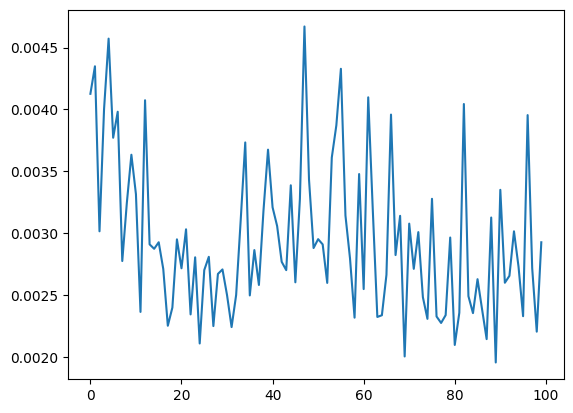

In [2]:
from B.utils import seed_everything
from B.autoencoder import train_autoencoder
import matplotlib.pyplot as plt
import numpy as np
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
seed_everything()
model, loss = train_autoencoder(xtrain)
plt.plot(loss)

In [5]:
from B.utils import seed_everything
import numpy as np
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
seed_everything()
import torch
from torch.utils.data import DataLoader, TensorDataset

# xtrain_norm = xtrain/255.0
xtrain_tensor = torch.tensor(xtrain/255.0, dtype=torch.float32)
print(xtrain_tensor.shape)
xtrain_tensor = xtrain_tensor.permute(0, 3, 1, 2)
print(xtrain_tensor.shape)
# 创建数据加载器
xtrain_dataset = TensorDataset(xtrain_tensor, xtrain_tensor)
xtrain_data_loader = DataLoader(xtrain_dataset, batch_size=128, shuffle=True)


torch.Size([89996, 28, 28, 3])
torch.Size([89996, 3, 28, 28])


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from B.autoencoder import Autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Autoencoder()
model.to(device)
# Define the loss function and optimizer
model.load_state_dict(torch.load('B/Models/conv_autoencoder.pth'))
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# # Train the autoencoder
# num_epochs = 100
# for epoch in range(num_epochs):
#     for data in xtrain_data_loader:
#         img, _ = data
#         img = img.to(device)
#         optimizer.zero_grad()
#         output = model(img)
#         loss = criterion(output, img)
#         loss.backward()
#         optimizer.step()
#     if epoch % 5== 0:
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# # Save the model
# torch.save(model.state_dict(), 'B/Models/conv_autoencoder.pth')

cuda


<All keys matched successfully>

<Figure size 1600x1200 with 0 Axes>

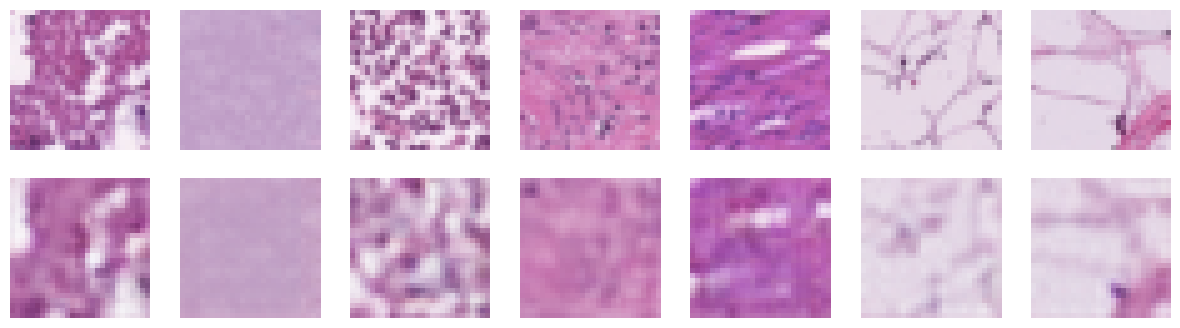

In [6]:
with torch.no_grad():
    for data, _ in xtrain_data_loader:
        data = data.to(device)
        recon = model(data)
        # encode = model.encoder(data)
        break
         
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    # ax[2, i].imshow(encode[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    # ax[2, i].axis('OFF')
plt.show()

In [7]:
with torch.no_grad():
    xtrain_new = model.encoder(xtrain_tensor.to(device))
    ntrain = len(xtrain)
    xtrain_encoded = xtrain_new.cpu().numpy().reshape(ntrain, -1)

In [8]:
type(xtrain_encoded)

numpy.ndarray

In [9]:
xtrain_encoded.shape

(89996, 392)

In [10]:
from sklearn.svm import SVC
C=0.8
kernel = 'linear'
svm = SVC(C=C, kernel=kernel, gamma='scale', probability=True)
svm.fit(xtrain_encoded, ytrain.ravel())

In [10]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(xtrain_encoded, ytrain.ravel())

RandomForestClassifier()

In [12]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# encode validation set
xval_tensor = torch.tensor(xval/255.0, dtype=torch.float32)
xval_tensor = xval_tensor.permute(0, 3, 1, 2)
with torch.no_grad():
    xval_new = model.encoder(xval_tensor.to(device))
    nval = len(xval)
    xval_encoded = xval_new.cpu().numpy().reshape(nval, -1)
print(accuracy_score(yval.ravel(), forest.predict(xval_encoded)))
print(classification_report(yval.ravel(), forest.predict(xval_encoded)))

0.6893242702918833
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1041
           1       1.00      0.89      0.94      1057
           2       0.64      0.42      0.51      1152
           3       0.86      0.85      0.85      1156
           4       0.55      0.59      0.57       890
           5       0.71      0.76      0.73      1354
           6       0.58      0.30      0.39       877
           7       0.53      0.54      0.54      1045
           8       0.55      0.78      0.64      1432

    accuracy                           0.69     10004
   macro avg       0.69      0.68      0.67     10004
weighted avg       0.69      0.69      0.68     10004



In [14]:
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
forest_new = RandomForestClassifier()
xtrain = xtrain.reshape((len(xtrain),-1))
forest_new.fit(xtrain, ytrain.ravel())

RandomForestClassifier()

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
print(accuracy_score(yval.ravel(), forest_new.predict(xval.reshape((len(xval),-1)))))
print(classification_report(yval.ravel(), forest_new.predict(xval.reshape((len(xval),-1)))))

0.6644342263094762
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1041
           1       0.99      0.89      0.94      1057
           2       0.64      0.34      0.45      1152
           3       0.75      0.81      0.78      1156
           4       0.52      0.61      0.56       890
           5       0.66      0.76      0.71      1354
           6       0.57      0.19      0.28       877
           7       0.52      0.52      0.52      1045
           8       0.53      0.75      0.62      1432

    accuracy                           0.66     10004
   macro avg       0.67      0.65      0.64     10004
weighted avg       0.67      0.66      0.65     10004



In [11]:
# # 实例化模型
# import torch
# import torch.nn as nn
# import torch.optim as optim
# # 实例化模型
# model = Autoencoder()

# # 损失函数和优化器
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 训练循环
# num_epochs = 30
# for epoch in range(num_epochs):
#     for data,_ in xtrain_data_loader:
#         # 前向传播
#         reconstructed = model(data)
#         loss = criterion(reconstructed, data)

#         # 反向传播
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.005635481793433428
Epoch 2, Loss: 0.0040120030753314495
Epoch 3, Loss: 0.004128783941268921
Epoch 4, Loss: 0.005691438913345337
Epoch 5, Loss: 0.004411508794873953
Epoch 6, Loss: 0.005608439911156893
Epoch 7, Loss: 0.0056043341755867004
Epoch 8, Loss: 0.005397894885390997
Epoch 9, Loss: 0.004827058408409357
Epoch 10, Loss: 0.005777726415544748
Epoch 11, Loss: 0.00520608015358448
Epoch 12, Loss: 0.006277692969888449
Epoch 13, Loss: 0.004608688410371542
Epoch 14, Loss: 0.0044650305062532425
Epoch 15, Loss: 0.0061465417966246605
Epoch 16, Loss: 0.004001167137175798
Epoch 17, Loss: 0.004429259803146124
Epoch 18, Loss: 0.004113239701837301
Epoch 19, Loss: 0.005761394742876291
Epoch 20, Loss: 0.005548187997192144
Epoch 21, Loss: 0.005184928420931101
Epoch 22, Loss: 0.0067665353417396545
Epoch 23, Loss: 0.007917813025414944
Epoch 24, Loss: 0.005898990202695131
Epoch 25, Loss: 0.005134483799338341
Epoch 26, Loss: 0.0033124315086752176
Epoch 27, Loss: 0.004374121781438589
Epoch

In [12]:
# torch.save(model.state_dict(), 'B/Models/linear_autoencoder.pth')

In [14]:
# # 使用编码器提取特征
# with torch.no_grad():  # 确保不计算梯度
#     encoded_features = model.encoder(xtrain_tensor)
# print(encoded_features[0].shape)

torch.Size([1, 7, 7])


### Resnet 18

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from B.preprocessing import *
from B.utils import seed_everything
seed_everything()
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
train_dataloader, val_dataloader, test_dataloader = preprocessing_resnet(xtrain, ytrain, xval, yval, xtest, ytest, batch_size=128)

In [3]:
ytrain.shape

(89996, 1)

In [1]:
import torch
import torchvision.models as models
model = models.resnet18(pretrained = False)
num_classes = 9
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

model = models.resnet18(pretrained = True)
for name, child in model.named_children():
    print(name)
    if name in ['layer4']:  # 只有layer4会被保留为可训练
        for param in child.parameters():
            param.requires_grad = True
    else:  # 其他层被冻结
        for param in child.parameters():
            param.requires_grad = False
# # 冻结前面的层
# for param in model.parameters():
#     param.requires_grad = False
num_classes = 9
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loss, val_accuracy = [], []
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images) # forward
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_loss.append(running_loss/len(train_dataloader))
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    val_accuracy.append(val_acc)
    print(f'Epoch {epoch+1}, Training Loss: {training_loss[-1]}, Validation Accuracy: {val_acc}')
print("training complete")
print(training_loss, val_accuracy)

Epoch 1, Training Loss: 0.18456125895185818, Validation Accuracy: 0.9666133546581367
Epoch 2, Training Loss: 0.08354709062471309, Validation Accuracy: 0.9645141943222711
Epoch 3, Training Loss: 0.057921071826223684, Validation Accuracy: 0.9654138344662135
Epoch 4, Training Loss: 0.0427488796389794, Validation Accuracy: 0.9569172331067572
Epoch 5, Training Loss: 0.030115571570025746, Validation Accuracy: 0.9676129548180727
Epoch 6, Training Loss: 0.031247553134645303, Validation Accuracy: 0.9773090763694522
Epoch 7, Training Loss: 0.019773044699976792, Validation Accuracy: 0.9713114754098361
Epoch 8, Training Loss: 0.020310850906298583, Validation Accuracy: 0.967313074770092
Epoch 9, Training Loss: 0.02141969104274143, Validation Accuracy: 0.9738104758096762
Epoch 10, Training Loss: 0.015220462084626392, Validation Accuracy: 0.9719112355057977


KeyboardInterrupt: 

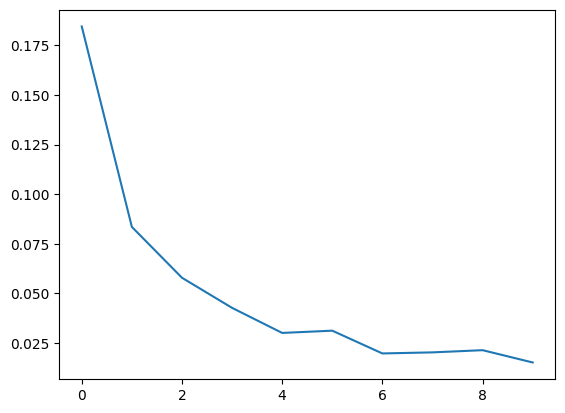

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = correct / total
val_accuracy.append(val_acc)
print(f' Validation Accuracy: {val_acc}')

 Validation Accuracy: 0.9759096361455418


c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.20527992775367404, Validation Accuracy: 0.9698120751699321
Epoch 2, Training Loss: 0.0588587599572334, Validation Accuracy: 0.9724110355857657
Epoch 3, Training Loss: 0.023378668366852005, Validation Accuracy: 0.9682127149140344
Epoch 4, Training Loss: 0.015050445330747276, Validation Accuracy: 0.9730107956817273
Epoch 5, Training Loss: 0.013634296883041812, Validation Accuracy: 0.9685125949620151
Epoch 6, Training Loss: 0.01131267300504326, Validation Accuracy: 0.9752099160335865
Epoch 7, Training Loss: 0.007254111845006925, Validation Accuracy: 0.9706117552978808
Epoch 8, Training Loss: 0.008749132552814197, Validation Accuracy: 0.9721111555377849
Epoch 9, Training Loss: 0.005832809655223834, Validation Accuracy: 0.9729108356657337
Epoch 10, Training Loss: 0.009338228709628476, Validation Accuracy: 0.9703118752499
training complete


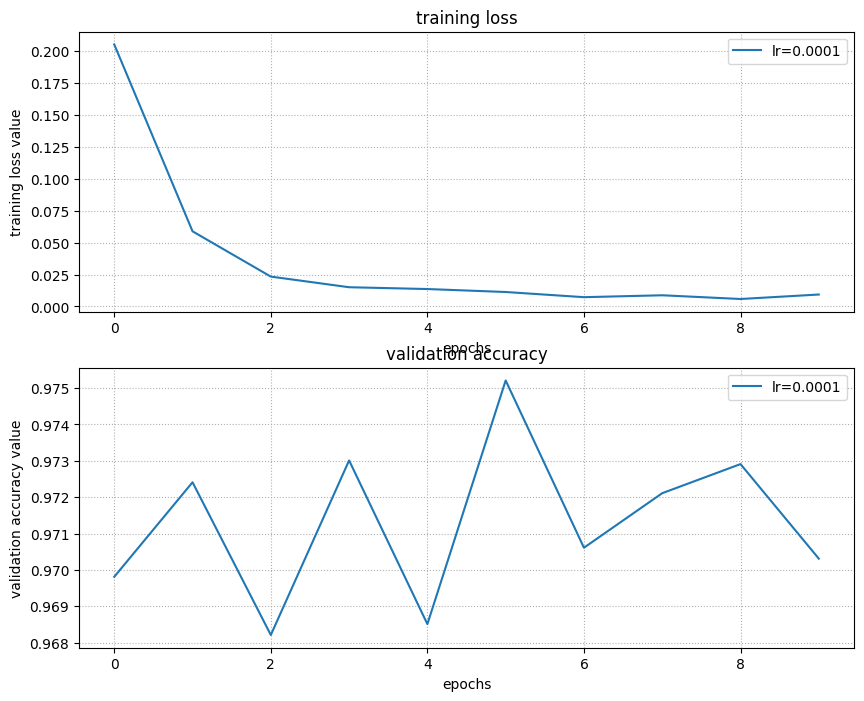

In [2]:
from B.resnet import *
import numpy as np
from B.preprocessing import *
seed_everything(seed=42)
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
train_dataloader, val_dataloader, test_dataloader = preprocessing_resnet(xtrain, ytrain, xval, yval, xtest, ytest, batch_size=128)
fig, ax = plt.subplots(2, 1, figsize=(10,8))
model = ResNetModel()
training_loss, val_accuracy = train_resnet(model, train_dataloader, val_dataloader, lr=0.0001)
ax[0].plot(training_loss, label=f'lr=0.0001')
ax[1].plot(val_accuracy, label=f'lr=0.0001')

ax[0].set_xlabel("epochs")
ax[0].set_ylabel("training loss value")
ax[0].set_title("training loss")        
ax[0].legend()
ax[0].grid(ls=':')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("validation accuracy value")
ax[1].set_title("validation accuracy")
ax[1].legend()
ax[1].grid(ls=':')

In [3]:
training_loss1, val_accuracy1 = train_resnet(model, train_dataloader, val_dataloader, scheduling=True)
ax[0].plot(training_loss1, label='lr scheduling')
ax[1].plot(val_accuracy1, label='lr scheduling')

Epoch 0: current lr=[0.001]
Epoch 1, Training Loss: 0.1166948742897644, Validation Accuracy: 0.9676129548180727
Epoch 1: current lr=[0.001]
Epoch 2, Training Loss: 0.061680707592379556, Validation Accuracy: 0.9679128348660536
Epoch 2: current lr=[0.001]
Epoch 3, Training Loss: 0.04512503313079916, Validation Accuracy: 0.9745101959216314
Epoch 3: current lr=[0.001]
Epoch 4, Training Loss: 0.03829894048001072, Validation Accuracy: 0.9719112355057977
Epoch 4: current lr=[0.0001]
Epoch 5, Training Loss: 0.03606909572747761, Validation Accuracy: 0.9734106357457017
Epoch 5: current lr=[0.0001]
Epoch 6, Training Loss: 0.0076707803579500414, Validation Accuracy: 0.983406637345062
Epoch 6: current lr=[0.0001]
Epoch 7, Training Loss: 0.004327665251914616, Validation Accuracy: 0.98390643742503
Epoch 7: current lr=[0.0001]
Epoch 8, Training Loss: 0.0027100836295426752, Validation Accuracy: 0.98390643742503
Epoch 8: current lr=[0.0001]
Epoch 9, Training Loss: 0.0024103627667645096, Validation Accur

In [7]:
model = ResNetModel(unfreeze_layers=['layer3', 'layer4'])
training_loss2, val_accuracy2 = train_resnet(model, train_dataloader, val_dataloader, scheduling=True)
ax[0].plot(training_loss2, label='unfreeze layer 3,4')
ax[1].plot(val_accuracy2, label='unfreeze layer 3,4')

c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: current lr=[0.001]
Epoch 1, Training Loss: 0.18070600006665866, Validation Accuracy: 0.9642143142742903
Epoch 1: current lr=[0.001]
Epoch 2, Training Loss: 0.0924448057723401, Validation Accuracy: 0.9519192323070772
Epoch 2: current lr=[0.001]
Epoch 3, Training Loss: 0.06435718289470639, Validation Accuracy: 0.9764094362255098
Epoch 3: current lr=[0.001]
Epoch 4, Training Loss: 0.046519740757503314, Validation Accuracy: 0.9735105957616953
Epoch 4: current lr=[0.0001]
Epoch 5, Training Loss: 0.036368998119211356, Validation Accuracy: 0.9794082367053178
Epoch 5: current lr=[0.0001]
Epoch 6, Training Loss: 0.009520345071781445, Validation Accuracy: 0.9875049980007997
Epoch 6: current lr=[0.0001]
Epoch 7, Training Loss: 0.004647939269799198, Validation Accuracy: 0.989204318272691
Epoch 7: current lr=[0.0001]
Epoch 8, Training Loss: 0.003712557320547851, Validation Accuracy: 0.9895041983206717
Epoch 8: current lr=[0.0001]
Epoch 9, Training Loss: 0.0024022277455215276, Validation Ac

In [8]:
torch.save(model.state_dict(), 'B/Models/bestresnet.pth')

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = correct / total
val_accuracy.append(val_acc)
print(f' Validation Accuracy: {val_acc}')

 Validation Accuracy: 0.9894042383046782


In [19]:
legend = fig.legend()

In [22]:
legend.set_visible(False)

In [24]:
fig.canvas.draw()

In [26]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [30]:
plt

<module 'matplotlib.pyplot' from 'c:\\Users\\qy\\anaconda3\\envs\\amls\\lib\\site-packages\\matplotlib\\pyplot.py'>

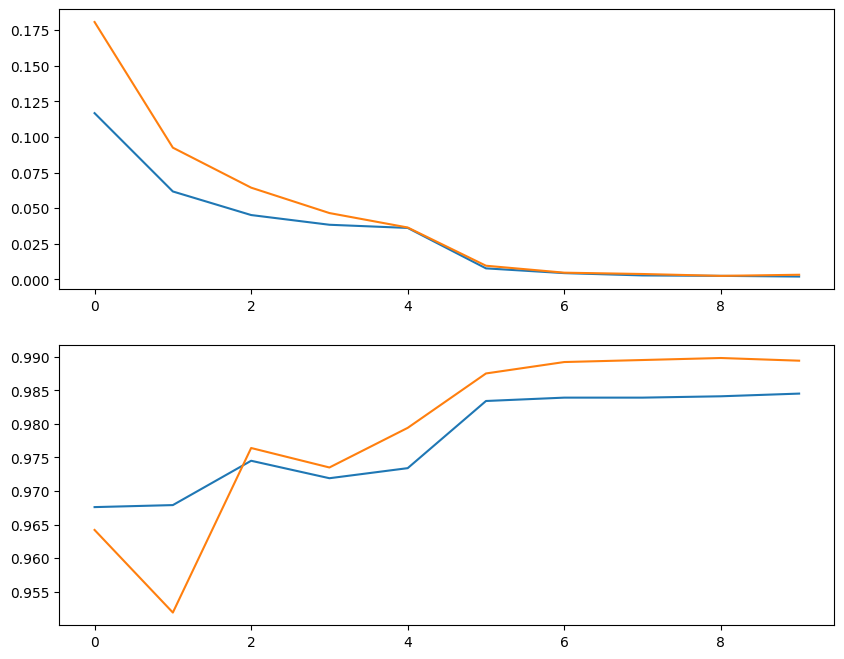

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(training_loss, label='lr scheduling')
ax[1].plot(val_accuracy, label='lr scheduling')
ax[0].plot(training_loss2, label='unfreeze layer 3,4')
ax[1].plot(val_accuracy2, label='unfreeze layer 3,4')

In [35]:
val_accuracy

[0.9676129548180727,
 0.9679128348660536,
 0.9745101959216314,
 0.9719112355057977,
 0.9734106357457017,
 0.983406637345062,
 0.98390643742503,
 0.98390643742503,
 0.9841063574570172,
 0.9845061975209916,
 0.9139275766016713,
 0.9894042383046782]

In [36]:
val_accuracy = val_accuracy[:10]

In [37]:
val_accuracy

[0.9676129548180727,
 0.9679128348660536,
 0.9745101959216314,
 0.9719112355057977,
 0.9734106357457017,
 0.983406637345062,
 0.98390643742503,
 0.98390643742503,
 0.9841063574570172,
 0.9845061975209916]

In [40]:
model = ResNetModel()
training_loss3, val_accuracy3 = train_resnet(model, train_dataloader, val_dataloader, lr=0.001)
ax[0].plot(training_loss3, label=f'lr=0.001')
ax[1].plot(val_accuracy3, label=f'lr=0.001')

ax[0].set_xlabel("epochs")
ax[0].set_ylabel("training loss value")
ax[0].set_title("training loss")        
ax[0].legend()
ax[0].grid(ls=':')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("validation accuracy value")
ax[1].set_title("validation accuracy")
ax[1].legend()
ax[1].grid(ls=':')

c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.17839812964137475, Validation Accuracy: 0.9653138744502199
Epoch 2, Training Loss: 0.08642563812662213, Validation Accuracy: 0.9643142742902839
Epoch 3, Training Loss: 0.05404608182884245, Validation Accuracy: 0.9705117952818872
Epoch 4, Training Loss: 0.03883298572046359, Validation Accuracy: 0.9746101559376249
Epoch 5, Training Loss: 0.03641529538774855, Validation Accuracy: 0.9716113554578168
Epoch 6, Training Loss: 0.02763841431119958, Validation Accuracy: 0.9750099960015993
Epoch 7, Training Loss: 0.018311553419752356, Validation Accuracy: 0.9757097161135546
Epoch 8, Training Loss: 0.021856523998601253, Validation Accuracy: 0.9698120751699321
Epoch 9, Training Loss: 0.020739221633076257, Validation Accuracy: 0.9662135145941624
Epoch 10, Training Loss: 0.015729118507816896, Validation Accuracy: 0.9779088364654138
training complete


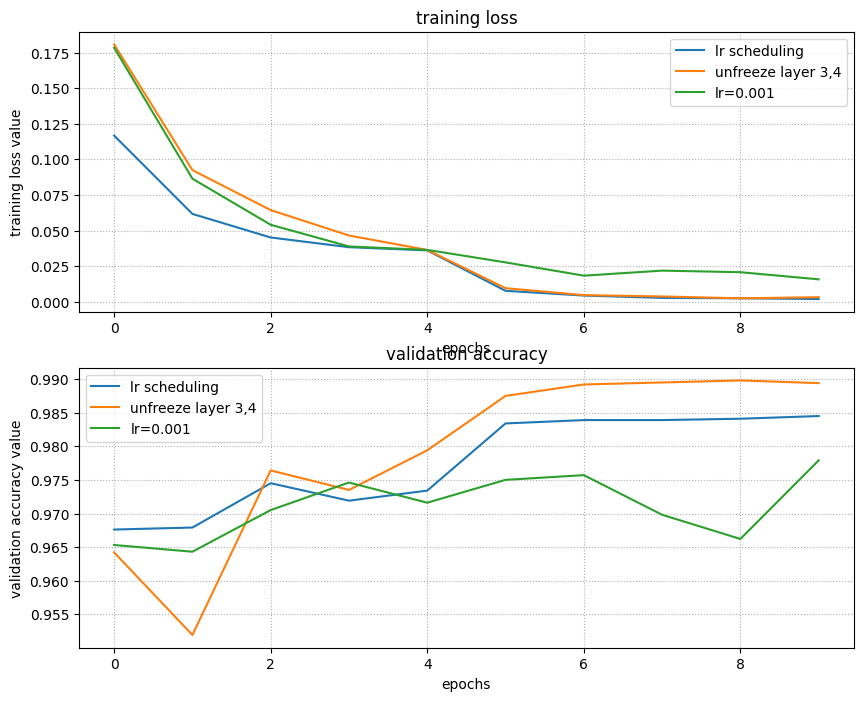

In [42]:
train_dataloader, val_dataloader, test_dataloader = preprocessing_resnet(xtrain, ytrain, xval, yval, xtest, ytest, batch_size=128)
model = ResNetModel()
training_loss4, val_accuracy4 = train_resnet(model, train_dataloader, val_dataloader, lr=0.0001)
ax[0].plot(training_loss4, label=f'lr=0.0001')
ax[1].plot(val_accuracy4, label=f'lr=0.0001')

c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.20440644137455488, Validation Accuracy: 0.9685125949620151
Epoch 2, Training Loss: 0.05927638453960588, Validation Accuracy: 0.9723110755697721
Epoch 3, Training Loss: 0.02411142630080576, Validation Accuracy: 0.9716113554578168
Epoch 4, Training Loss: 0.012897507747931575, Validation Accuracy: 0.9743102758896441
Epoch 5, Training Loss: 0.014250097393001355, Validation Accuracy: 0.9698120751699321
Epoch 6, Training Loss: 0.007729440410209711, Validation Accuracy: 0.9713114754098361
Epoch 7, Training Loss: 0.008438213845321034, Validation Accuracy: 0.9689124350259896
Epoch 8, Training Loss: 0.010831276884490844, Validation Accuracy: 0.9747101159536186
Epoch 9, Training Loss: 0.008354235925956098, Validation Accuracy: 0.973610555777689
Epoch 10, Training Loss: 0.005408191606958016, Validation Accuracy: 0.9755097960815674
training complete


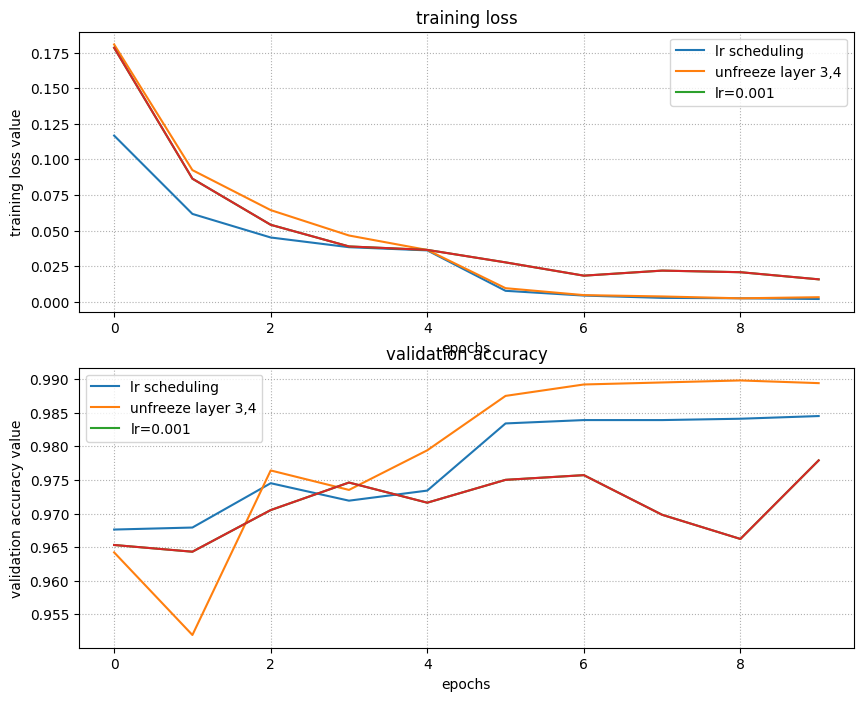

In [43]:
fig

In [44]:
ax[0].plot(training_loss4, label=f'lr=0.0001')
ax[1].plot(val_accuracy4, label=f'lr=0.0001')

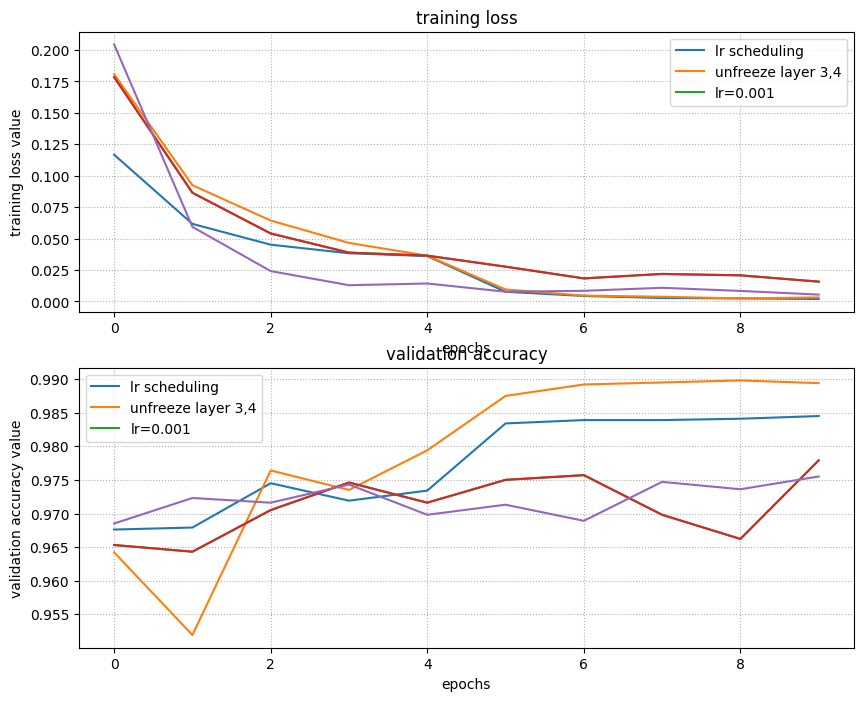

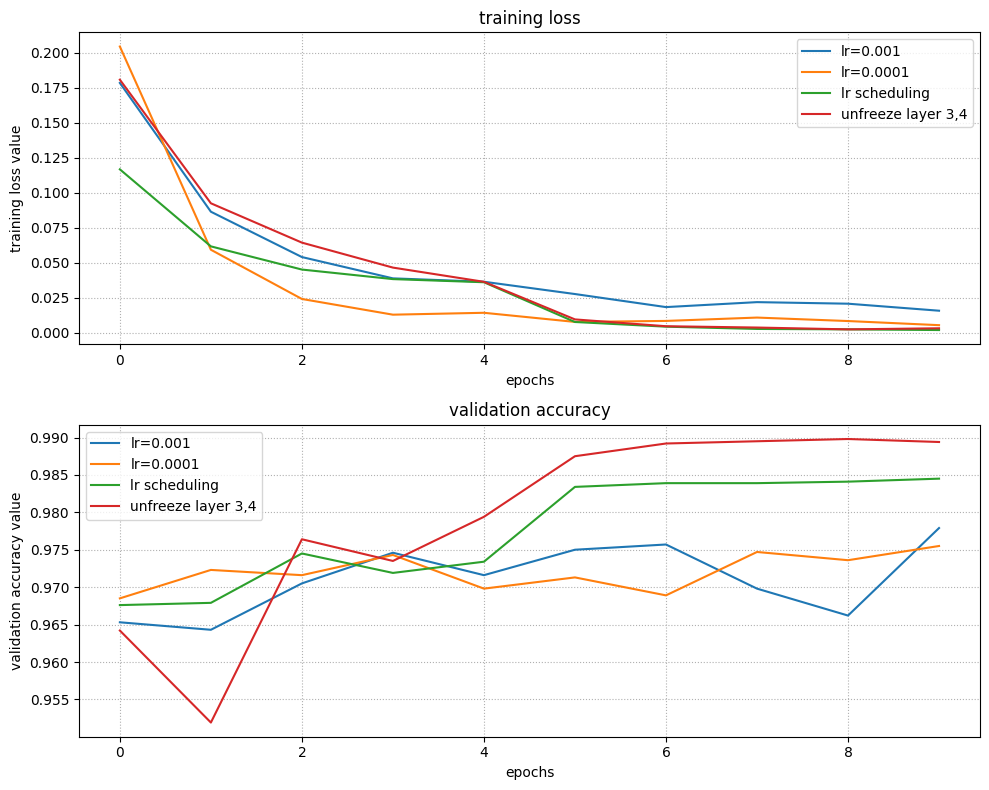

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(training_loss3, label=f'lr=0.001')
ax[1].plot(val_accuracy3, label=f'lr=0.001')
ax[0].plot(training_loss4, label=f'lr=0.0001')
ax[1].plot(val_accuracy4, label=f'lr=0.0001')
ax[0].plot(training_loss, label='lr scheduling')
ax[1].plot(val_accuracy, label='lr scheduling')
ax[0].plot(training_loss2, label='unfreeze layer 3,4')
ax[1].plot(val_accuracy2, label='unfreeze layer 3,4')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("training loss value")
ax[0].set_title("training loss")        
ax[0].legend()
ax[0].grid(ls=':')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("validation accuracy value")
ax[1].set_title("validation accuracy")
ax[1].legend()
ax[1].grid(ls=':')
plt.tight_layout()
plt.savefig("B/figures/resnet_tuning.png")

In [47]:
plt.savefig("B/figures/resnet_tuning.png")

<Figure size 640x480 with 0 Axes>

In [1]:
from B.preprocessing import *
from B.resnet import *
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import torch
from torchvision import transforms
from sklearn.metrics import accuracy_score

seed_everything(seed=42)
print("loading data...")
data = np.load('./Datasets/pathmnist.npz')
xtrain, ytrain, xval, yval, xtest, ytest = data["train_images"], data["train_labels"], data["val_images"], data["val_labels"], data["test_images"], data["test_labels"]
data.close()
print("loading data complete...")

print("load fine-tuned ResNet model...")
train_dataloader, val_dataloader, test_dataloader = preprocessing_resnet(xtrain, ytrain, xval, yval, xtest, ytest)
resnet = ResNetModel(num_classes=9, unfreeze_layers=['layer3', 'layer4'], pretrained=True)
resnet.load_state_dict(torch.load("B/Models/bestresnet.pth"))
val_acc_resnet = eval_resnet(resnet, val_dataloader)
test_acc_resnet = eval_resnet(resnet, test_dataloader)
print(f"val acc of resnet: {val_acc_resnet}, test acc of resnet: {test_acc_resnet}")

loading data...
loading data complete...
load fine-tuned ResNet model...


c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\amls\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


val acc of resnet: 0.9894042383046782, test acc of resnet: 0.9139275766016713


### Final Test

In [5]:
from B.main import *
train_all_models(train_randomforest=True)

loading data...
loading data complete...
train fine-tuned Random Forest model with autoencoder preprocessing...
val acc of random forest with feature extraction: 0.6955217912834866, test acc: 0.6802228412256267
without autoencoder preprocessing...
val acc of random forest without feature extraction: 0.6683326669332267, test acc: 0.63983286908078
load fine-tuned CNN model...
val ACC of CNN: 0.9045381847261096, test ACC of CNN: 0.8511142061281337
val AUC of CNN: 0.9806846274427229, test AUC of CNN: 0.9717300733762014
load fine-tuned ResNet model...


c:\Users\qy\anaconda3\envs\testenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\qy\anaconda3\envs\testenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


val acc of resnet: 0.9894042383046782, test acc: 0.9139275766016713


In [6]:
from A.main import *
train_all_models()

loading data...
loading data complete...
train fine-tuned KNN model...
val acc of KNN: 0.9522900763358778, test acc of KNN: 0.8301282051282052
train fine-tuned SVM model...
val acc of SVM: 0.9599236641221374, test acc of SVM: 0.8669871794871795
load fine-tuned CNN model with data augmentation...
val ACC of CNN: 0.9656488549618321, test ACC of CNN: 0.8717948717948718
val AUC of CNN: 0.9936589545844045, test AUC of CNN: 0.9430309007232085
load fine-tuned CNN model without data augmentation...
val ACC of CNN: 0.9618320610687023, test ACC of CNN: 0.8798076923076923
val AUC of CNN: 0.994877654003618, test AUC of CNN: 0.9428336620644314


In [2]:
show_tuning_process(show_knn=False, show_svm=False)

loading data...
loading data complete
plot the tuning of k in KNN in range 1-80...


KeyboardInterrupt: 